## Taller 1 – EDA-Florida-AndresGutierrez

Este notebook contiene información de Airbnb en **Florida**, y se abordará el problema con el siguiente enfoque:



### Preguntas clave:
   - ¿Qué tipos de propiedades son más populares o tienen mayor demanda?
   - ¿Cuáles son las zonas o ubicaciones más rentables?
   - ¿Cómo influyen las calificaciones en la tasa de ocupación o en el precio por noche? (mejorar)
   - ¿Qué rangos de precios son los más adecuados?
   - ¿ Qué servicios se relacionan más con la demanda de los usuarios?



# Setup

In [1]:

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "florida"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Get the data

In [2]:
import pandas as pd

# import data from a csv
listings = pd.read_csv('data/listings.csv')


# Entendimiento Inicial de datos

In [3]:
# Showing dataframe dimensions
listings.shape

(17728, 75)

### Dataset Dimensions:
Number of Records: 17,728  
Number of Attributes: 18


## Feature Selection:

In [4]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [5]:
listings_allfeatures = listings.copy()

### Create new features

Las preguntas de negocio que se plantean al inicio dependen de la creación de las siguientes variabes:  

1) Demanda/tasa de ocupación  
2) Rentabilidad Bruta esperada Anualmente 




#### Demand
Para ello usaré `availability_*` y `host_acceptance_rate` para entender cuántas solicitudes se generan. Se usa una heuristica basada en el articulo ""...

**Asumptions**  
Nota 1: Con el proxy de demanda se puede caer en estacionalidades, pero hacen falta más datos para evitar este problema.

Nota 2: El diccionario de datos se refiere a `availability_*` como las fechas disponibles en * dias, ya sea por reserva o por que el usuario bloquea.

In [6]:
# List of columns we are interested in
cols_to_check = ['availability_30', 'availability_60', 'availability_90', 'availability_365', 'host_acceptance_rate']

# Check for missing values in each column
missing_values = listings_allfeatures[cols_to_check].isnull().sum()

# Print the number of missing values for each column
print(missing_values)


availability_30            0
availability_60            0
availability_90            0
availability_365           0
host_acceptance_rate    1822
dtype: int64


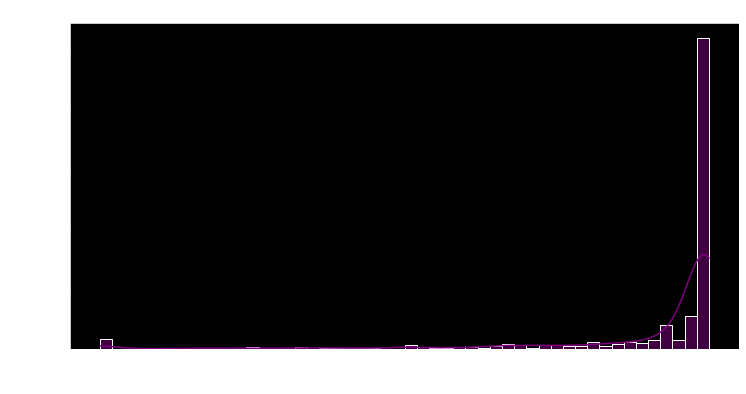

In [7]:
# Cleaning the host_acceptance_rate column
listings_allfeatures['host_acceptance_rate'] = listings_allfeatures['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
# Histogram for the distribution of host_acceptance_rate
plt.figure(figsize=(12, 6))

# Plotting the distribution of host_acceptance_rate
sns.histplot(listings_allfeatures['host_acceptance_rate'], bins=50, kde=True, color='purple')
plt.title('Distribution of Host Acceptance Rate')
plt.xlabel('Host Acceptance Rate')
plt.ylabel('Number of Listings')

plt.show()


In [8]:
# Calculate the median of host_acceptance_rate for each property_type
median_per_property_type = listings_allfeatures.groupby('property_type')['host_acceptance_rate'].median()
global_median = listings_allfeatures['host_acceptance_rate'].median()

# Function to impute missing values based on median for each property_type
def impute_median(row):
    if pd.isnull(row['host_acceptance_rate']):
        return median_per_property_type.get(row['property_type'], global_median)
    else:
        return row['host_acceptance_rate']

listings_allfeatures['host_acceptance_rate'] = listings_allfeatures.apply(impute_median, axis=1)

# Filter the DataFrame to keep only rows where host_acceptance_rate
# Calculate upper and lower bounds based on mean and standard deviation
mean_host_acceptance_rate = listings_allfeatures['host_acceptance_rate'].mean()
std_host_acceptance_rate = listings_allfeatures['host_acceptance_rate'].std()
lower_bound = mean_host_acceptance_rate - 1.5 * std_host_acceptance_rate

listings_allfeatures = listings_allfeatures[listings_allfeatures['host_acceptance_rate'] >= lower_bound]



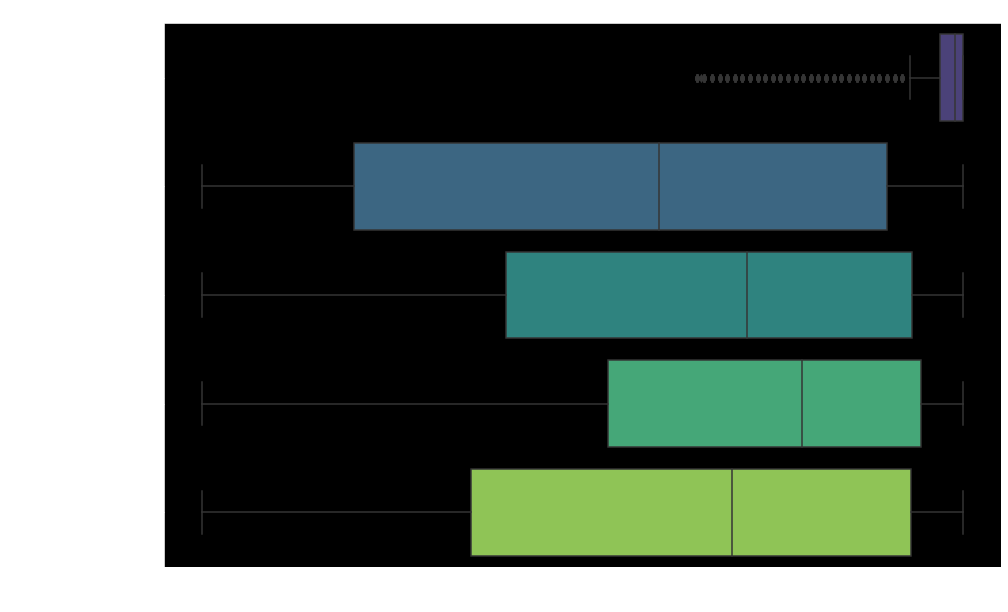

In [9]:
demand_inputs = ['host_acceptance_rate', 'availability_30', 'availability_60', 'availability_90', 'availability_365']
# Convert availability columns to percentage format
demand_inputs_df = pd.DataFrame()
demand_inputs_df['availability_30'] = listings_allfeatures['availability_30'] / 30
demand_inputs_df['availability_60'] = listings_allfeatures['availability_60'] / 60
demand_inputs_df['availability_90'] = listings_allfeatures['availability_90'] / 90
demand_inputs_df['availability_365'] = listings_allfeatures['availability_365'] / 365
demand_inputs_df['host_acceptance_rate'] = listings_allfeatures['host_acceptance_rate']

# Plot the updated boxplots for each column in demand_inputs
plt.figure(figsize=(15, 10))
sns.boxplot(data=demand_inputs_df[demand_inputs], orient='h', palette='viridis')
plt.title('Boxplots for Demand-Related Variables (in Percentage)')
plt.xlabel('Percentage')
plt.ylabel('Variable')

plt.show()

In [10]:
# Describe the columns in demand_inputs
demand_inputs_description = listings_allfeatures[demand_inputs].describe()
demand_inputs_description

,host_acceptance_rate,availability_30,availability_60,availability_90,availability_365
count,16602.000000,16602.000000,16602.000000,16602.000000,16602.000000
mean,0.963117,16.259728,37.491989,61.050536,224.013010
std,0.069789,10.895758,20.380720,29.409270,122.536482
min,0.650000,0.000000,0.000000,0.000000,0.000000
25%,0.970000,6.000000,24.000000,48.000000,129.000000
50%,0.990000,18.000000,43.000000,71.000000,254.000000
75%,1.000000,27.000000,56.000000,85.000000,340.000000
max,1.000000,30.000000,60.000000,90.000000,365.000000


In [11]:
# Define the weights
w_30 = 0.6
w_60 = 0.3
w_90 = 0.1
# Calculate demand
listings_allfeatures['monthly_demand'] = (
    (w_30 * (30 - listings_allfeatures['availability_30']) + 
    w_60 * (60 - listings_allfeatures['availability_60'])/2 + 
    w_90 * (90 - listings_allfeatures['availability_90'])/3  )
    * listings_allfeatures['host_acceptance_rate']
)

# Drop news nan
listings_allfeatures.dropna(subset = ['monthly_demand'],inplace = True)

#### Valor esperado
Ahora debemos crear una nueva columna llamada `expected_revenue`, que representará los ingresos esperados en función del producto de la demanda  

In [12]:
# clean the price attribute 
listings_allfeatures["price"] = listings_allfeatures["price"].str.replace("[$,]", "", regex=True).astype(float)
# Calculate the expected revenue by multiplying 'demand' with 'price'
listings_allfeatures['monthly_revenue'] = listings_allfeatures['monthly_demand'] * listings_allfeatures['price']

*Se seleccionan del set de datos las variables para trabajar* 
Para los valores númericos se hace uso de la correlación con factor de decisión y las preguntas de negocio que plantea el caso
Para los valores Categoricos de los papers y las preguntas de negocio que plantea el caso Sengupta et al. (2021) y  Kirkos (2021) 

In [13]:
# Columns to be removed
columns_to_remove = ['monthly_demand', 'availability_60', 'availability_90', 'availability_30','availability_365', 'price','host_acceptance_rate'] # las quito por la construcción de la variable

numeric_features = listings_allfeatures.select_dtypes(include=['float64', 'int64'])
numeric_features = numeric_features.drop(columns=columns_to_remove, errors='ignore')

corr_matrix = numeric_features.corr()
top_3_numeric_features = corr_matrix["monthly_revenue"].abs().sort_values(ascending=False).head(3)
top_3_numeric_features

monthly_revenue    1.000000
bedrooms           0.297730
accommodates       0.277222
Name: monthly_revenue, dtype: float64

In [14]:
# Identifier column
identifier = ['id']

# Features related to the property details
property_features = ['property_type','amenities','price', 'longitude', 'latitude','neighbourhood_cleansed','instant_bookable','accommodates']

# Features related to host
host_features = ['host_is_superhost']

# New Features
new_features = ['monthly_demand','monthly_revenue']

# Combining the features into one list
top_features = identifier + property_features + host_features + new_features
top_df = listings_allfeatures[top_features].copy()

# Display the first rows of the adjusted DataFrame
top_df.head()

,id,property_type,amenities,price,longitude,latitude,neighbourhood_cleansed,instant_bookable,accommodates,host_is_superhost,monthly_demand,monthly_revenue
0,57818,Entire home,"[""Garden view"", ""Bathtub"", ""Microwave"", ""Lake ...",275.0,-80.12430,26.01859,Hollywood,f,4,t,28.356333,7797.991667
1,83449,Entire rental unit,"[""Host greets you"", ""Bathtub"", ""Smoke alarm"", ...",91.0,-80.14201,26.03392,Dania Beach,f,5,f,28.500000,2593.500000
2,3097603,Entire rental unit,"[""Smoke alarm"", ""Free parking on premises"", ""E...",300.0,-80.37207,26.12660,Weston,f,8,f,29.700000,8910.000000
3,3105046,Entire rental unit,"[""Smoke alarm"", ""Hot tub"", ""Free parking on pr...",105.0,-80.37142,26.12751,Weston,f,4,f,29.700000,3118.500000
4,3113463,Private room in home,"[""Bathtub"", ""Lake access"", ""Shared pool"", ""Hot...",65.0,-80.13118,26.20928,Pompano Beach,t,2,NaN,1.566667,101.833333


# Data quality

### Duplicated values

In [15]:
nid_duplicated = top_df.duplicated().sum()
ndata_duplicated = top_df.duplicated().sum()

assert nid_duplicated == 0 or ndata_duplicated == 0 , "¡Error! Hay IDs duplicados en el dataset."


### Missing values

In [16]:
# Data Types and nans information
top_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16602 entries, 0 to 17727
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      16602 non-null  int64  
 1   property_type           16602 non-null  object 
 2   amenities               16602 non-null  object 
 3   price                   16602 non-null  float64
 4   longitude               16602 non-null  float64
 5   latitude                16602 non-null  float64
 6   neighbourhood_cleansed  16602 non-null  object 
 7   instant_bookable        16602 non-null  object 
 8   accommodates            16602 non-null  int64  
 9   host_is_superhost       14834 non-null  object 
 10  monthly_demand          16602 non-null  float64
 11  monthly_revenue         16602 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 1.6+ MB


In [17]:
#%pip install missingno

In [18]:

import missingno as msno

missing_data = top_df.isnull()
complete_rows = top_df.dropna()
num_complete_rows = len(complete_rows)

sns.set_style("white")
print(f"Hay {num_complete_rows} filas sin valores faltantes en el dataset.")

Hay 14834 filas sin valores faltantes en el dataset.


In [19]:
missing_observation = top_df.isnull().sum()
missing_observation.sort_values(ascending=False)

host_is_superhost         1768
id                           0
property_type                0
amenities                    0
price                        0
longitude                    0
latitude                     0
neighbourhood_cleansed       0
instant_bookable             0
accommodates                 0
monthly_demand               0
monthly_revenue              0
dtype: int64

Antes de continuar con la imputación exploraré los otros datos con fin de mejorar los criterios  
de imputación

# Variables Analysis

### Demands

[]

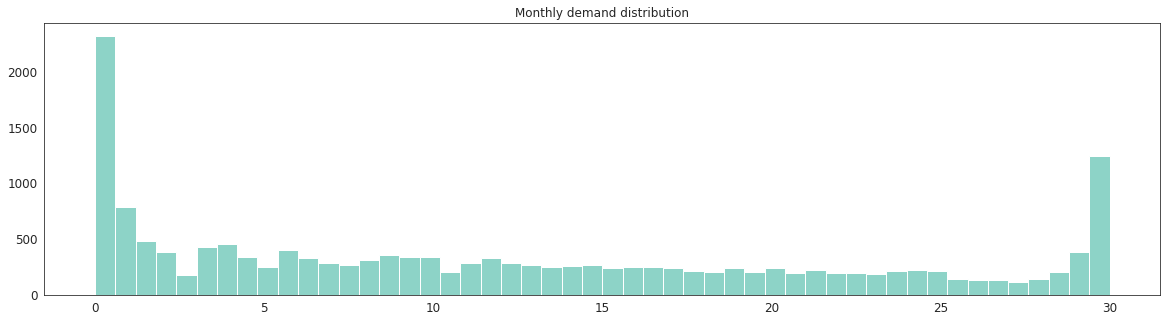

In [20]:
sns.set_style("white")
plt.figure(figsize=(20, 5))
plt.hist(top_df["monthly_demand"], bins=50)
plt.title("Monthly demand distribution")
plt.plot()

In [21]:
top_df["monthly_demand"].describe()

count    16602.000000
mean        12.157128
std          9.995813
min          0.000000
25%          2.976667
50%         10.345500
75%         20.365250
max         30.000000
Name: monthly_demand, dtype: float64

[]

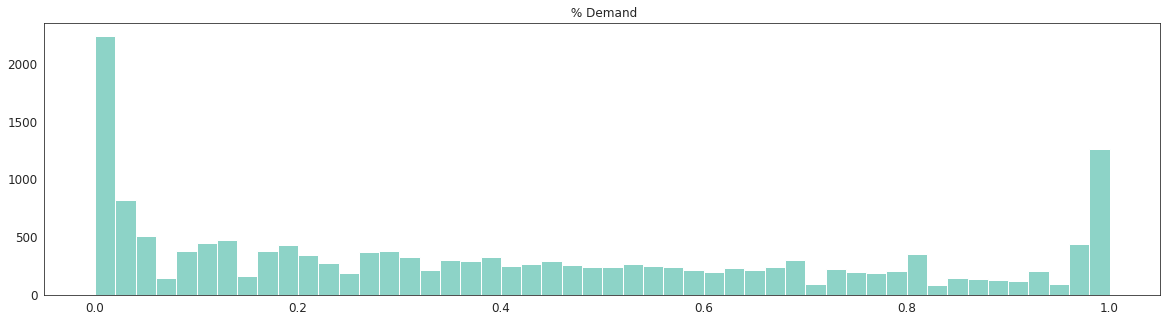

In [22]:
top_df["pp_demand"] = top_df["monthly_demand"]/30
top_df["pp_demand"] = top_df["pp_demand"].round(2)
sns.set_style("white")
plt.figure(figsize=(20, 5))
plt.hist(top_df["pp_demand"], bins=50)
plt.title(" % Demand")
plt.plot()

### Price

[]

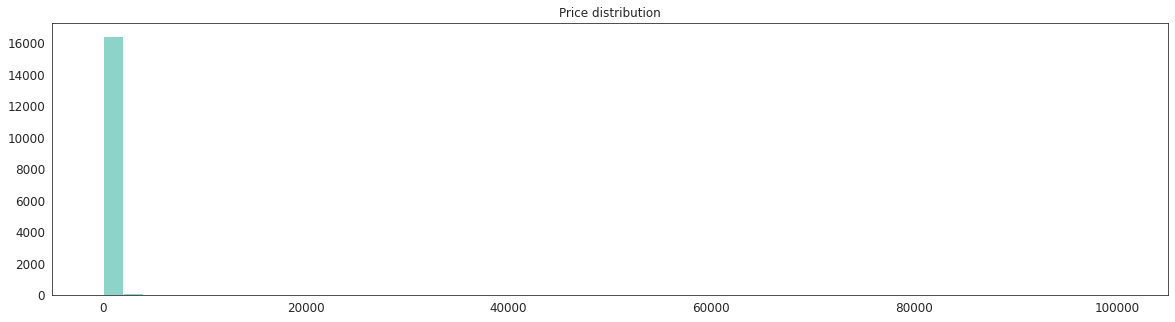

In [23]:
sns.set_style("white")
plt.figure(figsize=(20, 5))
plt.hist(top_df["price"], bins=50)
plt.title("Price distribution")
plt.plot()

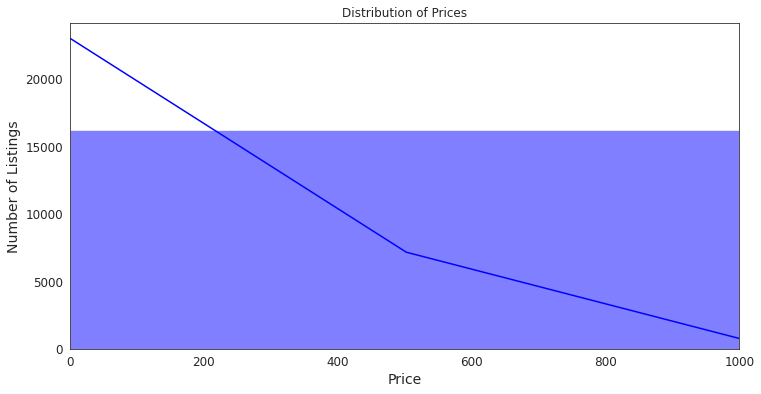

In [24]:
# Histogram for the distribution of prices
plt.figure(figsize=(12, 6))

# Plotting the distribution of prices
sns.histplot(top_df['price'], bins=100, kde=True, color='blue')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Number of Listings')
plt.xlim(0, 1000)  # Limiting the x-axis to focus on the majority of data

plt.show()

Procedo a quitar el quartil superior de precios

Text(0, 0.5, 'Number of Listings')

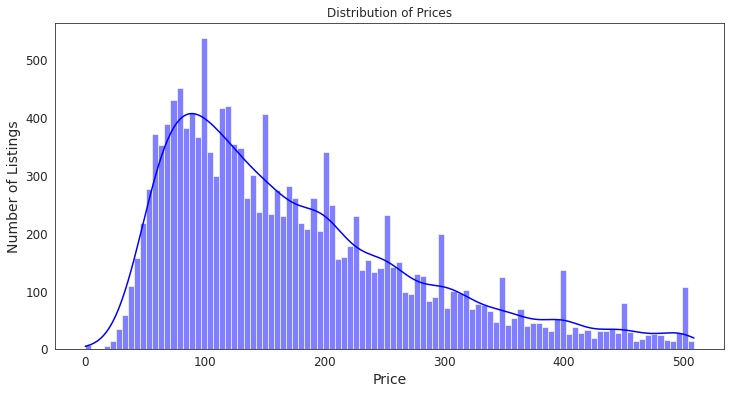

In [25]:
# Calculate the Interquartile Range (IQR) for the price column
q1 = top_df["price"].quantile(0.25)
q3 = top_df["price"].quantile(0.75)
iqr = q3 - q1

# Define bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter the DataFrame to exclude outliers based on the price_float column
filtered_top = top_df[ top_df["price"] <= upper_bound]

# Histogram for the distribution of prices
plt.figure(figsize=(12, 6))

# Plotting the distribution of prices
sns.histplot(filtered_top['price'], bins=100, kde=True, color='blue')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Number of Listings')

El histograma muestra la distribución de precios de las propiedades listadas en Airbnb en Florida:

La mayoría de las propiedades tienen precios en el rango de $0 a $200.
Hay un pico notable en el rango de precios de $50 a $100, lo que indica que este es un rango de precios común para muchas propiedades.
A medida que aumenta el precio, el número de listados disminuye, lo que es esperado ya que las propiedades de lujo o de alta gama suelen ser menos en número.

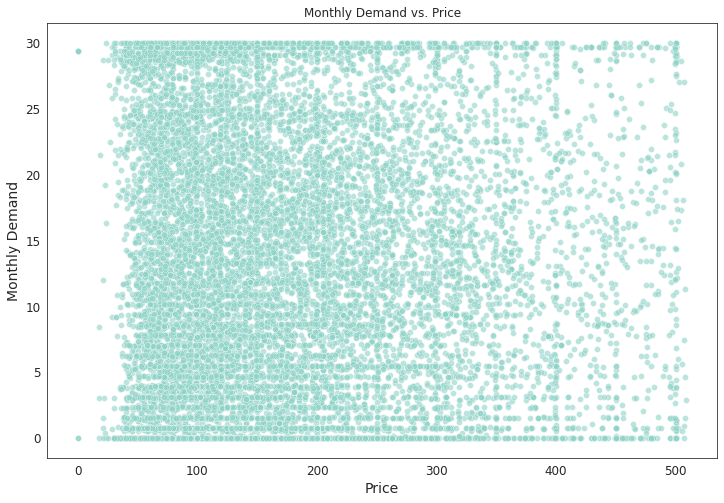

In [26]:
# Scatter plot for price vs. monthly_demand
plt.figure(figsize=(12, 8))
sns.scatterplot(data=filtered_top, x='price', y='monthly_demand', alpha=0.6)
plt.title('Monthly Demand vs. Price')
plt.xlabel('Price')
plt.ylabel('Monthly Demand')
plt.show()

El gráfico muestra la relación entre el "precio" y la "demanda mensual" estimada para las propiedades listadas en Airbnb en Florida:

- La mayoría de las propiedades tienen una demanda mensual en el rango más bajo, independientemente del precio. Esto sugiere que muchas propiedades no se alquilan con frecuencia.  
- No hay una relación lineal clara entre el precio y la demanda mensual. Sin embargo, se puede observar que las propiedades con precios más altos tienden a tener una menor demanda mensual en general.  

Esto sugiere que, si bien el precio es un factor, hay otros factores que también influyen en la demanda mensual, como la ubicación, las comodidades, las calificaciones de revisión y la disponibilidad general.

In [27]:
filtered_top.neighbourhood_cleansed.unique()

array(['Hollywood', 'Dania Beach', 'Weston', 'Pompano Beach',
       'Deerfield Beach', 'Fort Lauderdale', 'Miramar',
       'Lauderdale By The Sea', 'Plantation', 'Oakland Park',
       'Lauderhill', 'Tamarac', 'Margate', 'Pembroke Pines',
       'Wilton Manors', 'Sunrise', 'Hallandale Beach', 'Hillsboro Beach',
       'Davie', 'Lighthouse Point', 'Coconut Creek', 'Lauderdale Lakes',
       'West Park', 'Southwest Ranches', 'North Lauderdale', 'Parkland',
       'Cooper City', 'Pembroke Park', 'Unincorporated',
       'County Regional Facility', 'Coral Springs', 'Tribal Land',
       'Lazy Lake', 'Sea Ranch Lakes'], dtype=object)

# Discover and visualize the data to gain insights

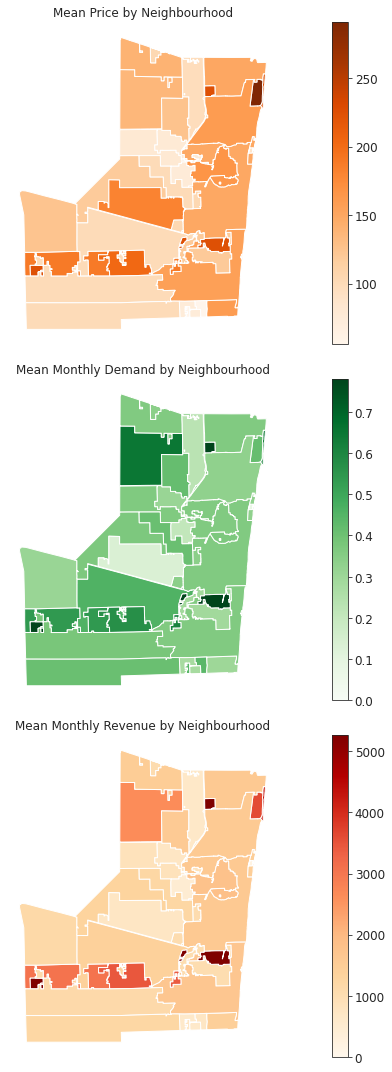

In [28]:
import geopandas as gpd

## Load the geojson file into a GeoDataFrame
neighbourhoods_gdf = gpd.read_file("data/neighbourhoods.geojson")

# Merge the neighbourhoods data with the listings data to get average price and number of reviews per neighbourhood
merged_data = filtered_top.groupby('neighbourhood_cleansed').agg({'price': 'median', 'pp_demand': 'median'}).reset_index()
merged_data['monthly_revenue'] = merged_data['price'] * merged_data['pp_demand'] * 30
merged_data['monthly_revenue'] = merged_data['monthly_revenue'].round(1)
merged_data = neighbourhoods_gdf.merge(merged_data, left_on="neighbourhood", right_on="neighbourhood_cleansed")

# Plotting the merged data
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# Plot average price per neighbourhood
merged_data.plot(column='price', cmap="Oranges", legend=True, ax=ax[0])
ax[0].set_title("Mean Price by Neighbourhood")
ax[0].axis('off')

# Plot average monthly demand per neighbourhood
merged_data.plot(column='pp_demand', cmap="Greens", legend=True, ax=ax[1])
ax[1].set_title("Mean Monthly Demand by Neighbourhood")
ax[1].axis('off')

# Plot average monthly revenue per neighbourhood
merged_data.plot(column='monthly_revenue', cmap="OrRd", legend=True, ax=ax[2])
ax[2].set_title("Mean Monthly Revenue by Neighbourhood")
ax[2].axis('off')

plt.tight_layout()
plt.show()



In [29]:

# Drop duplicated rows based on the 'neighbourhood' column
merged_data_unique = merged_data.drop_duplicates(subset='neighbourhood', keep='first')

# Calculate top 5 neighbourhoods for each attribute
top_price_neighbourhoods_notebook = merged_data_unique.nlargest(5, 'price')[['neighbourhood', 'price']]
top_demand_neighbourhoods_notebook = merged_data_unique.nlargest(5, 'pp_demand')[['neighbourhood', 'pp_demand']]
top_revenue_neighbourhoods_notebook = merged_data_unique.nlargest(5, 'monthly_revenue')[['neighbourhood', 'monthly_revenue']]

top_price_neighbourhoods_notebook, top_demand_neighbourhoods_notebook, top_revenue_neighbourhoods_notebook


(               neighbourhood  price
 83          Lighthouse Point  290.5
 56  County Regional Facility  225.0
 76           Hillsboro Beach  224.0
 66               Cooper City  203.0
 40         Southwest Ranches  188.5,
                neighbourhood  pp_demand
 56  County Regional Facility      0.780
 55             Coral Springs      0.650
 76           Hillsboro Beach      0.635
 70               Tribal Land      0.610
 66               Cooper City      0.570,
                neighbourhood  monthly_revenue
 56  County Regional Facility           5265.0
 76           Hillsboro Beach           4267.2
 83          Lighthouse Point           3616.7
 66               Cooper City           3471.3
 70               Tribal Land           3431.2)

In [30]:
# Retrieve additional columns (price and monthly_demand) for the top 5 neighbourhoods based on monthly_revenue
top_revenue_neighbourhoods_detailed = merged_data_unique.nlargest(5, 'monthly_revenue')[['neighbourhood', 'monthly_revenue', 'price', 'pp_demand']]

top_revenue_neighbourhoods_detailed


,neighbourhood,monthly_revenue,price,pp_demand
56,County Regional Facility,5265.0,225.0,0.780
76,Hillsboro Beach,4267.2,224.0,0.635
83,Lighthouse Point,3616.7,290.5,0.415
66,Cooper City,3471.3,203.0,0.570
70,Tribal Land,3431.2,187.5,0.610


Dado que tenemos un listado de los barrios más rentables, de ahora en adelante  
se usará este df para explorar las otras variables.

### Neighbourhood Higth Revenue Segmentation

In [31]:
# 
neighbourhood_higth_revenue = filtered_top[filtered_top['neighbourhood_cleansed'].isin(top_revenue_neighbourhoods_detailed.neighbourhood.unique())]
neighbourhood_higth_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 134 to 17683
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      168 non-null    int64  
 1   property_type           168 non-null    object 
 2   amenities               168 non-null    object 
 3   price                   168 non-null    float64
 4   longitude               168 non-null    float64
 5   latitude                168 non-null    float64
 6   neighbourhood_cleansed  168 non-null    object 
 7   instant_bookable        168 non-null    object 
 8   accommodates            168 non-null    int64  
 9   host_is_superhost       158 non-null    object 
 10  monthly_demand          168 non-null    float64
 11  monthly_revenue         168 non-null    float64
 12  pp_demand               168 non-null    float64
dtypes: float64(6), int64(2), object(5)
memory usage: 18.4+ KB


### property_type

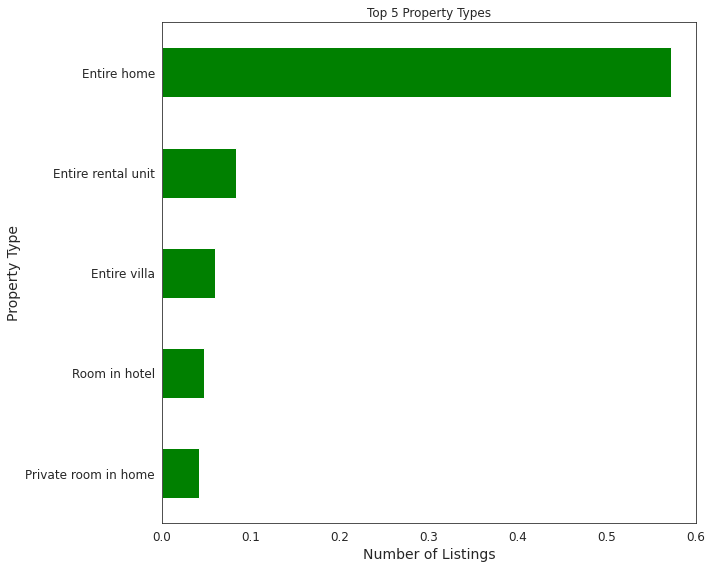

In [32]:
# Bar chart for the 5 most common property types
top_5_property_types = neighbourhood_higth_revenue["property_type"].value_counts(normalize = True).head(5)

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the top 10 property types with horizontal bars
top_5_property_types.plot(kind='barh', ax=ax, color='Green')

# Set the title and labels for the plot
ax.set_title('Top 5 Property Types')
ax.set_xlabel('Number of Listings')
ax.set_ylabel('Property Type')

# Invert the y-axis to display the property type with the most listings at the top
ax.invert_yaxis()

# Adjust layout to fit everything nicely
plt.tight_layout()

# Display the plot
plt.show()

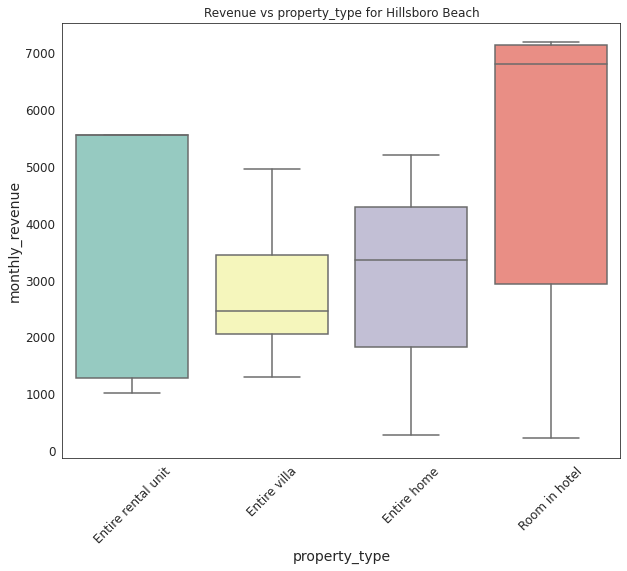

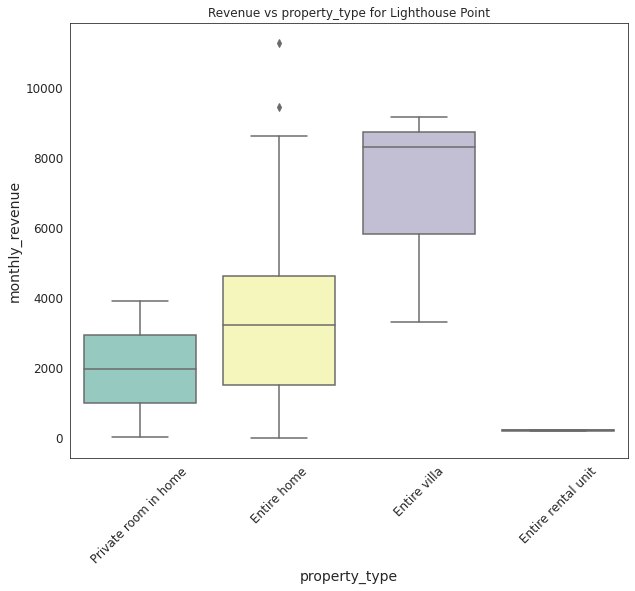

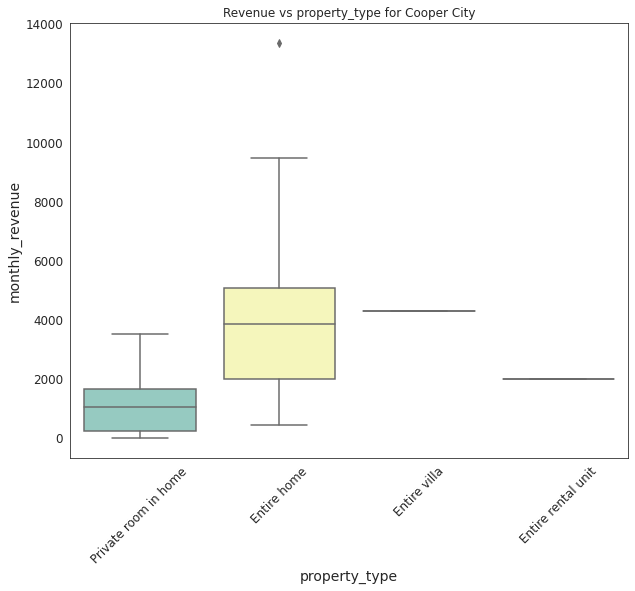

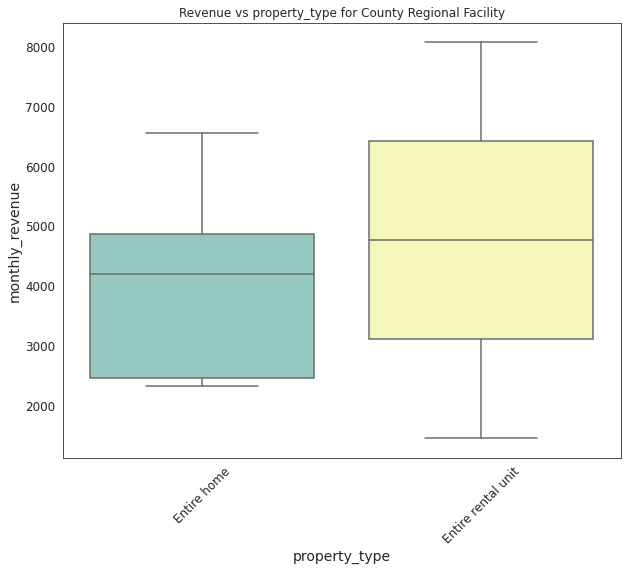

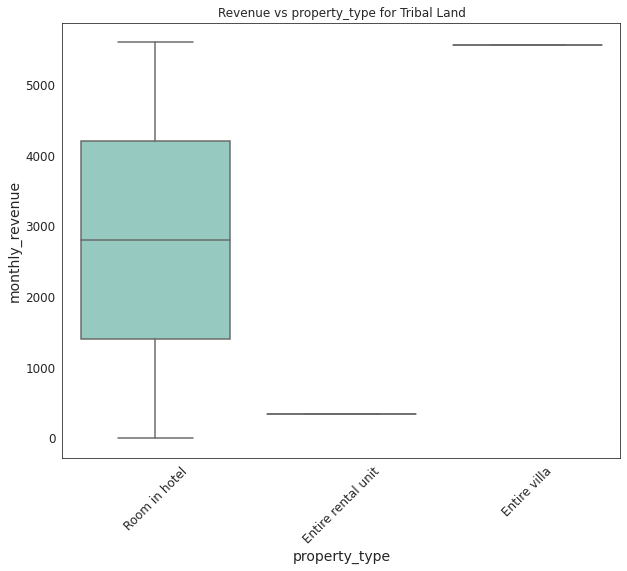

In [33]:
top_5_property_types = pd.DataFrame(top_5_property_types)
filtered_data = neighbourhood_higth_revenue[neighbourhood_higth_revenue['property_type'].isin(top_5_property_types.index.unique())]

for neighbourhood in neighbourhood_higth_revenue['neighbourhood_cleansed'].unique():
    neighbourhood_data = filtered_data[filtered_data['neighbourhood_cleansed'] == neighbourhood]

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.boxplot(data=neighbourhood_data, x='property_type', y='monthly_revenue', ax=ax)
    ax.set_title(f'Revenue vs property_type for {neighbourhood}')
    plt.xticks(rotation=45)
    plt.show()

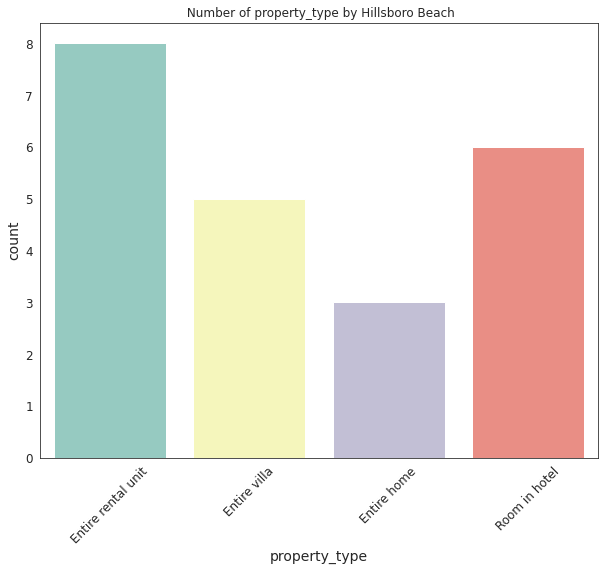

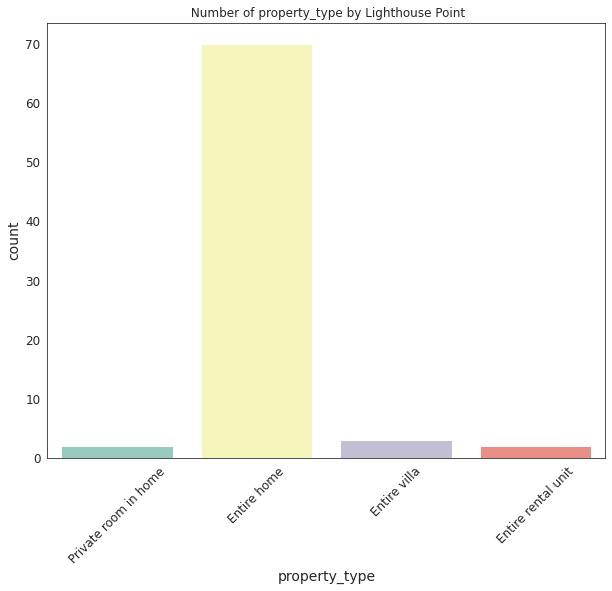

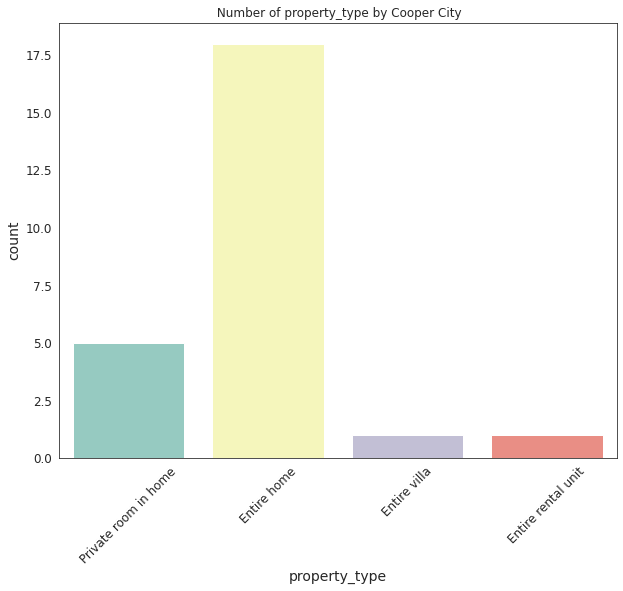

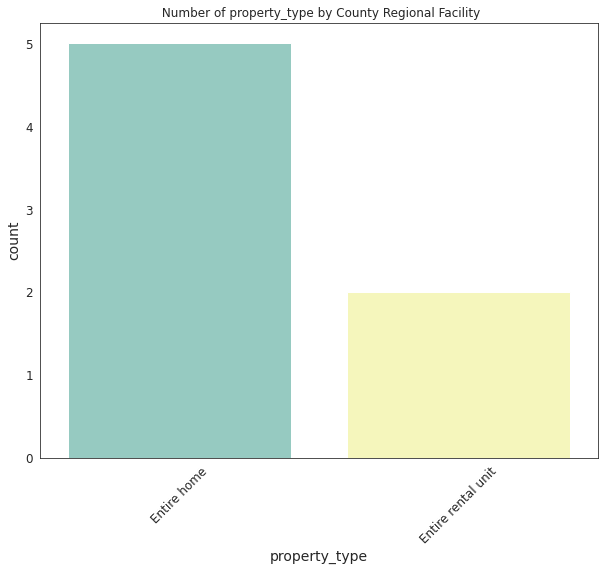

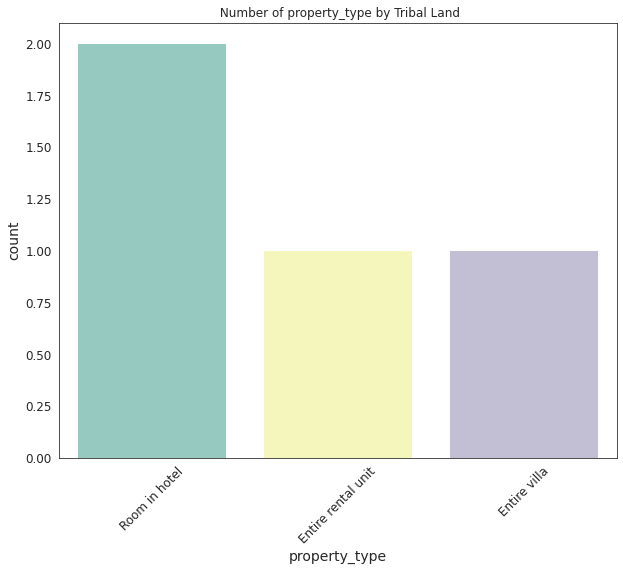

In [34]:
for neighbourhood in neighbourhood_higth_revenue['neighbourhood_cleansed'].unique():
    neighbourhood_data = filtered_data[filtered_data['neighbourhood_cleansed'] == neighbourhood]

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.countplot(data = neighbourhood_data, x='property_type', ax=ax)
    ax.set_title(f' Number of property_type by {neighbourhood}')
    plt.xticks(rotation=45)
    plt.show()

## Super Host

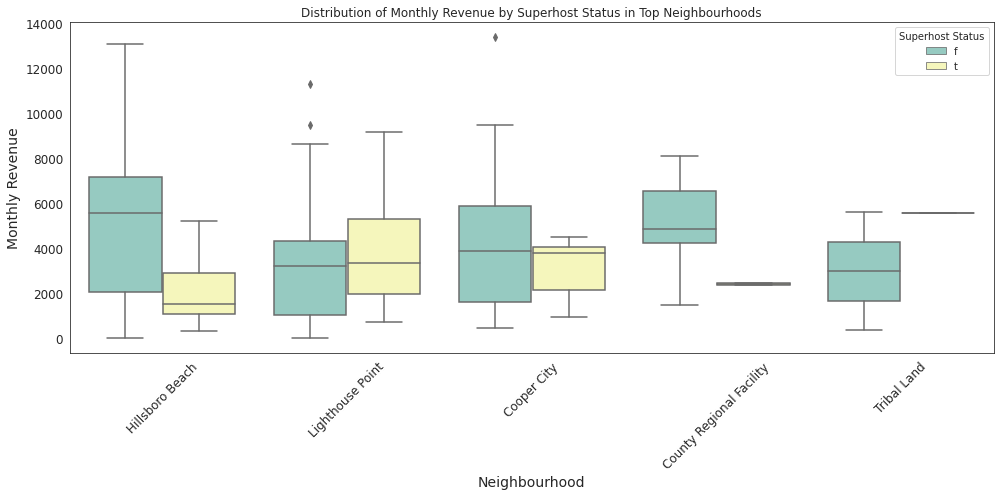

In [35]:

# Plotting the distribution of monthly revenue for Superhost and non-Superhost in top neighbourhoods
plt.figure(figsize=(14, 7))
sns.boxplot(data= neighbourhood_higth_revenue, x='neighbourhood_cleansed', y='monthly_revenue', hue='host_is_superhost')
plt.title('Distribution of Monthly Revenue by Superhost Status in Top Neighbourhoods')
plt.xticks(rotation=45)
plt.ylabel('Monthly Revenue')
plt.xlabel('Neighbourhood')
plt.legend(title='Superhost Status')
plt.tight_layout()
plt.show()


El gráfico muestra la distribución de los ingresos mensuales por estado de Superhost en los vecindarios con los mayores ingresos. Aquí hay algunas observaciones:

- Variabilidad en Ingresos: En general, hay una amplia variabilidad en los ingresos mensuales dentro de cada vecindario, independientemente del estado de Superhost.
- Superhost vs. No-Superhost: En la mayoría de los vecindarios, los anfitriones Superhost tienden a tener ingresos mensuales medianos más altos en comparación con los no-Superhost. Sin embargo, la diferencia no es drástica.
- Outliers: Hay varios outliers, especialmente en el vecindario "Chamberí". Estos outliers pueden ser propiedades de lujo o con características únicas que les permiten cobrar tarifas más altas.

## Amenities

In [36]:
# Extract amenities and create a list for each property
neighbourhood_higth_revenue['amenities_list'] = neighbourhood_higth_revenue['amenities'].str.replace("[{}]", "", regex=True).str.split(",")

# Expand the amenities into separate rows
amenities_exploded = neighbourhood_higth_revenue.explode('amenities_list')

# Count the occurrences of each amenity in top revenue neighbourhoods
amenities_count = amenities_exploded['amenities_list'].value_counts()




/tmp/ipykernel_16305/585493236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbourhood_higth_revenue['amenities_list'] = neighbourhood_higth_revenue['amenities'].str.replace("[{}]", "", regex=True).str.split(",")


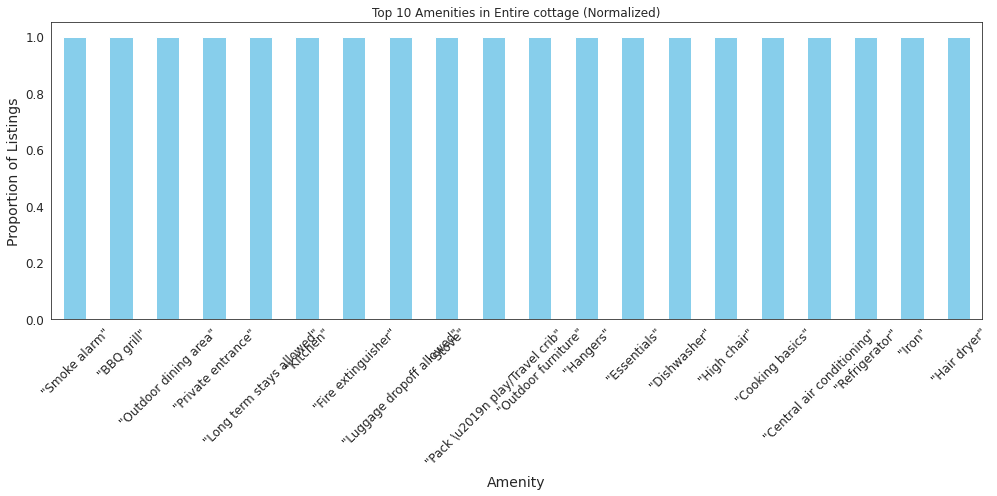

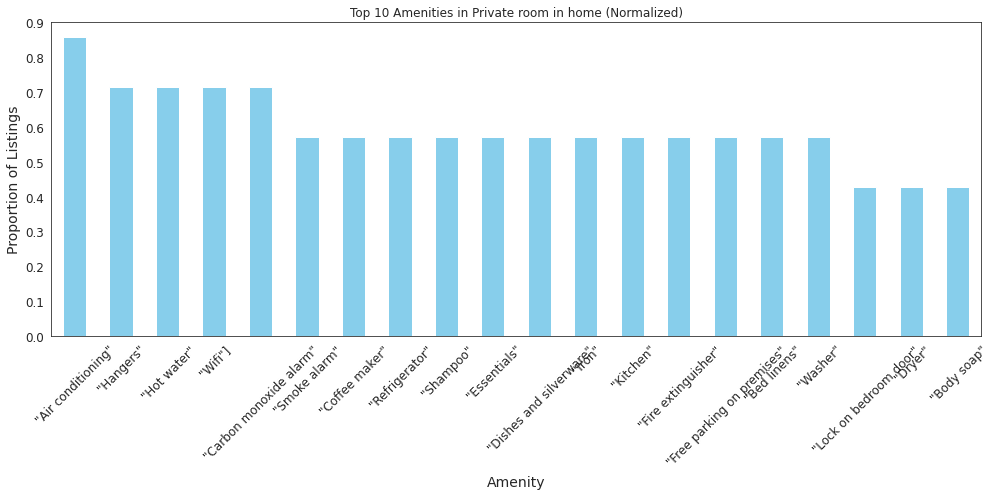

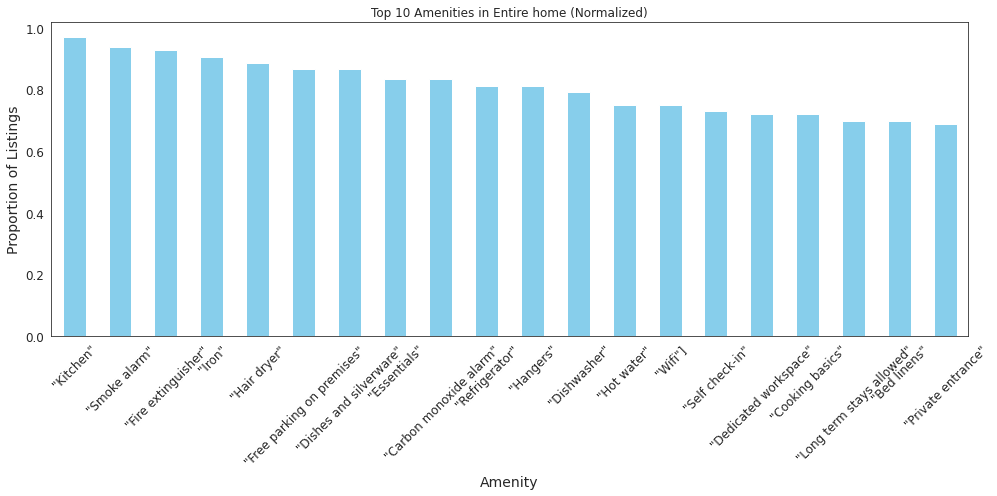

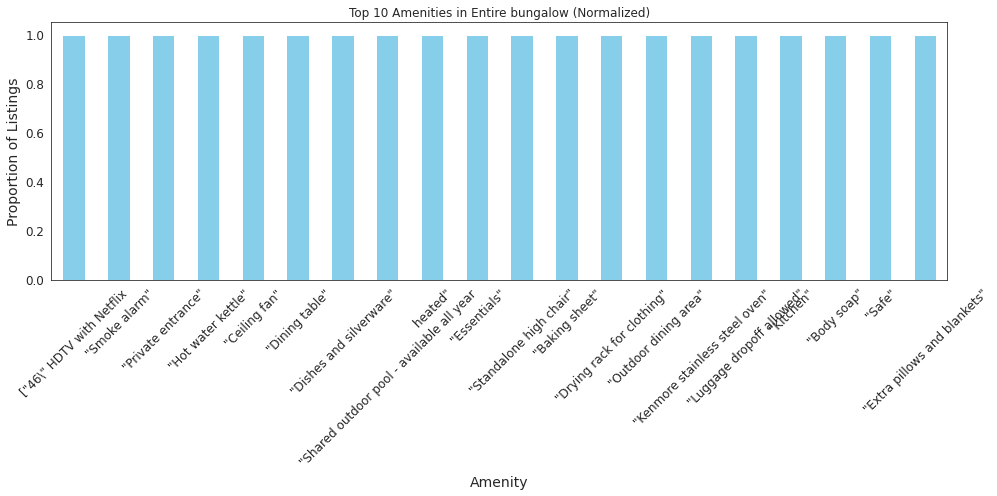

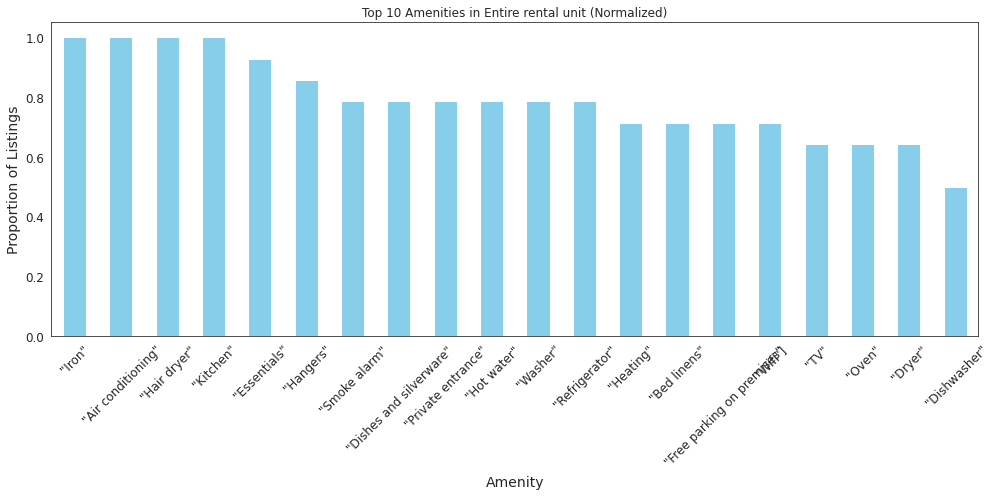

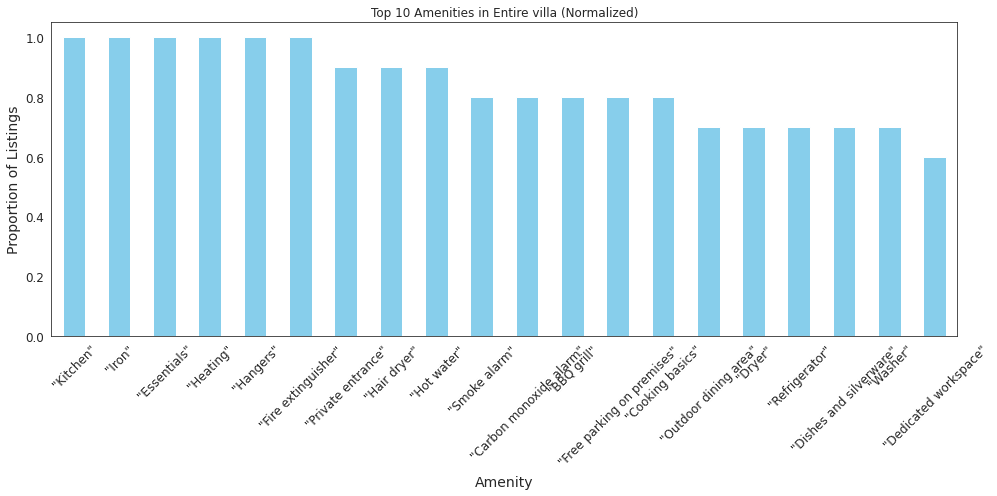

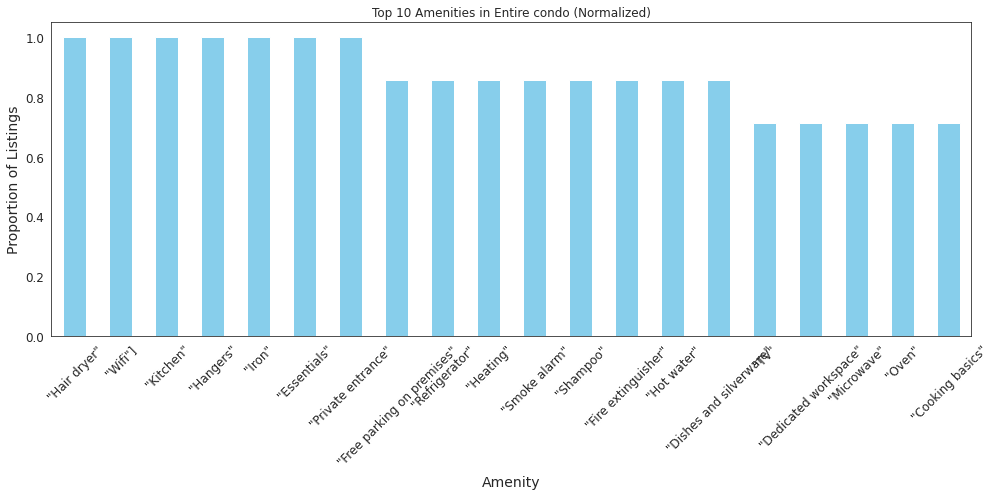

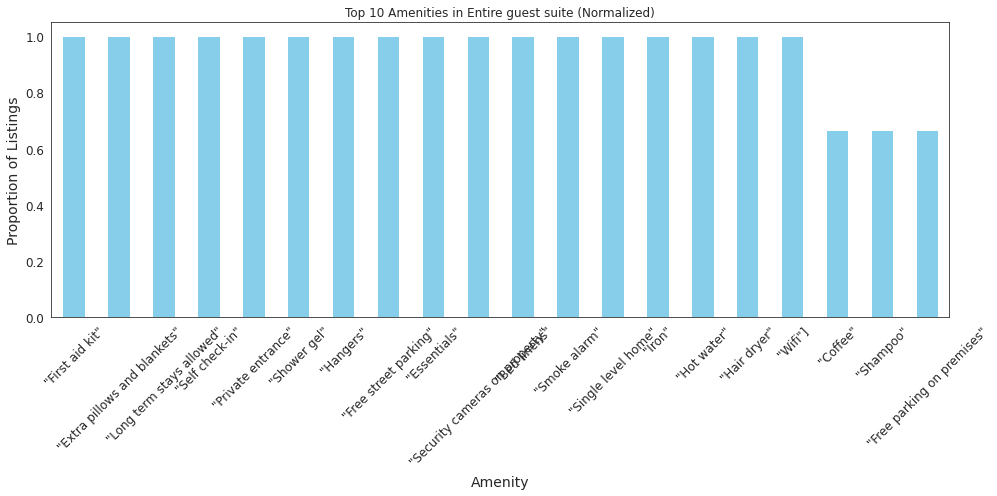

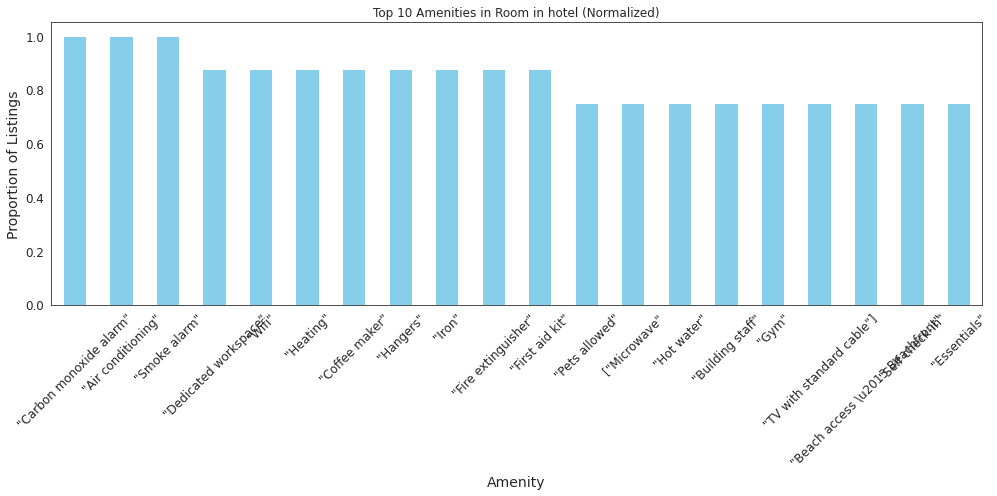

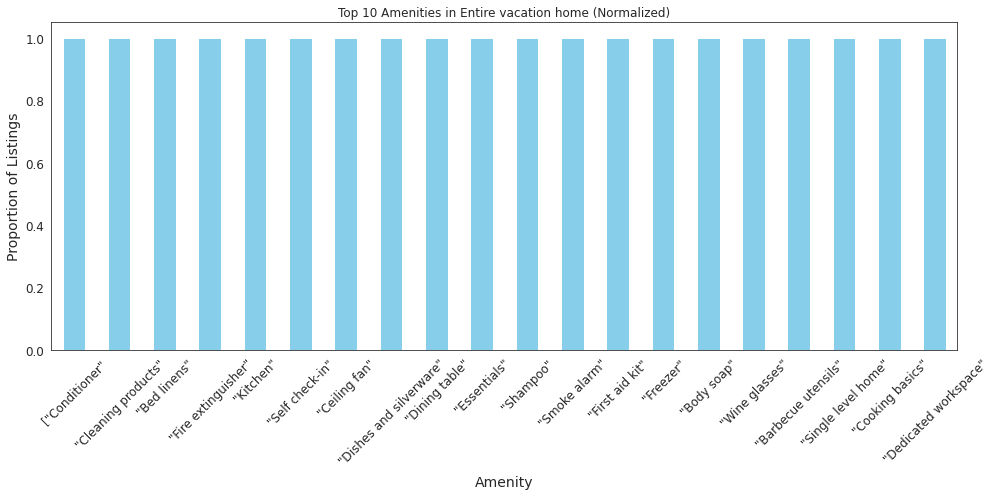

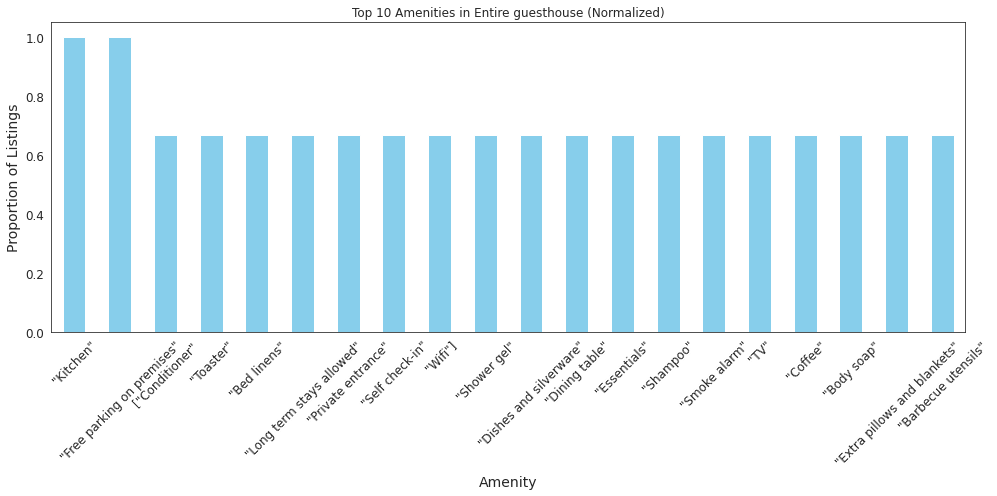

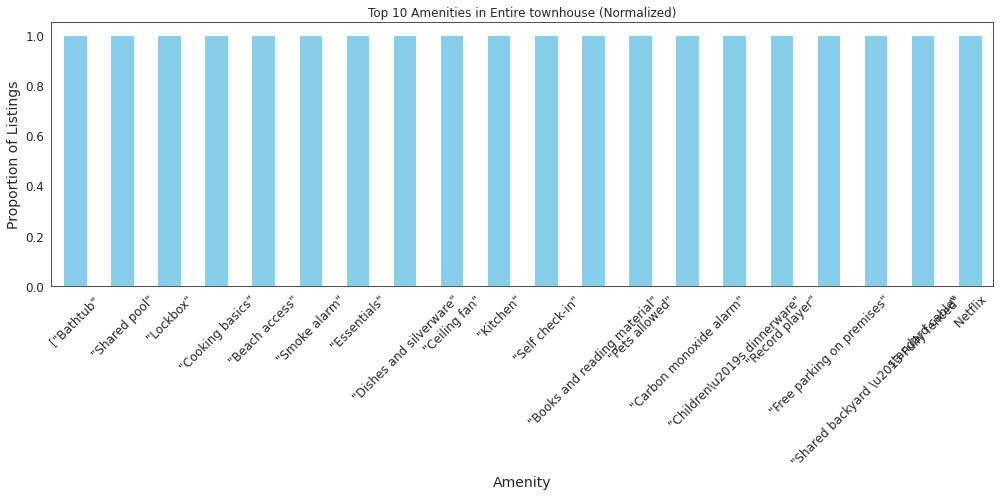

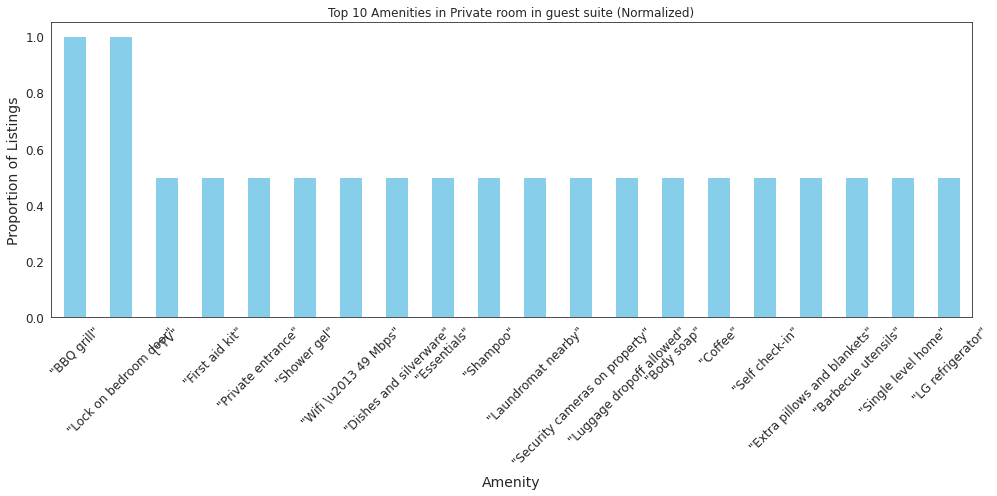

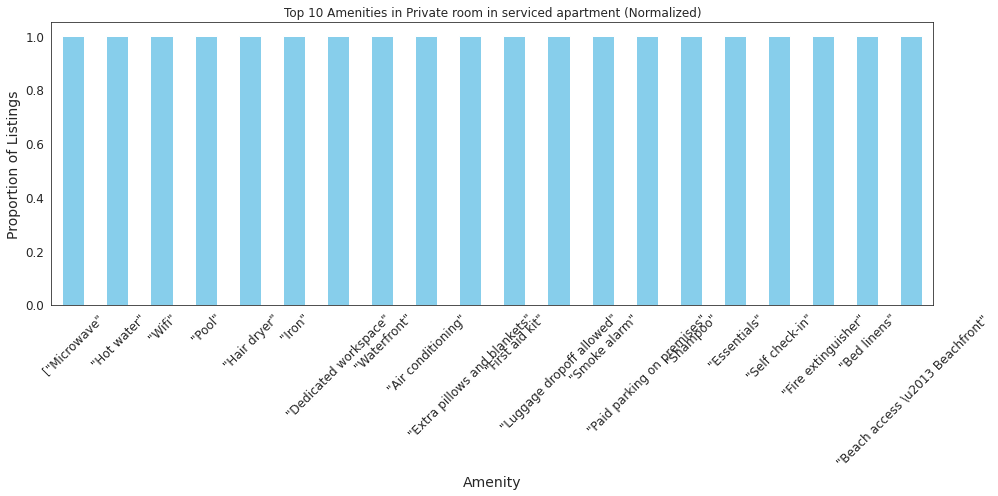

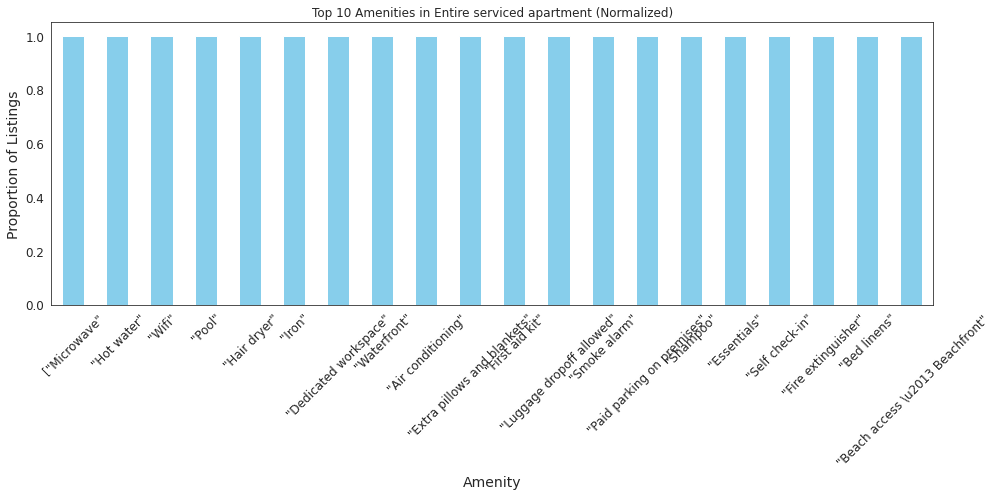

In [37]:
def plot_normalized_amenities_by_property_type(df):
    # Getting unique property types
    property_types = df['property_type'].unique()
    
    # For each property type, count the top 20 amenities and plot
    for prop_type in property_types:
        # Filtering data for current property type
        prop_data = df[df['property_type'] == prop_type]
        
        # Counting amenities
        amenities_count = prop_data['amenities'].str.split(',').explode().value_counts()
        
        # Normalizing the counts
        normalized_amenities_count = amenities_count / len(prop_data)
        
        # Plotting the top 20 normalized amenities for current property type
        plt.figure(figsize=(14, 7))
        normalized_amenities_count.head(20).plot(kind='bar', color='skyblue')
        plt.title(f'Top 10 Amenities in {prop_type} (Normalized)')
        plt.ylabel('Proportion of Listings')
        plt.xlabel('Amenity')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
plot_normalized_amenities_by_property_type(neighbourhood_higth_revenue)


El gráfico muestra las 10 comodidades más comunes en los vecindarios con los mayores ingresos. Aquí hay algunas observaciones:

Comodidades esenciales: Elementos como "Wifi", "Cocina", "Calefacción" y "Lavadora" están entre las comodidades más comunes, lo que indica que son consideradas esenciales por la mayoría de los anfitriones y probablemente esperadas por los huéspedes.
Comodidades de seguridad: La "Alarma de monóxido de carbono" y la "Alarma de humo" también son comunes, lo que sugiere una atención a la seguridad por parte de los anfitriones en estos vecindarios.
Accesibilidad: Las comodidades relacionadas con la accesibilidad, como "Ascensor", también son populares, lo que puede ser especialmente relevante en zonas urbanas con edificios de varios pisos.
El siguiente paso es analizar cómo estas comodidades pueden influir en los ingresos mensuales. Una forma de hacerlo es investigar si la presencia de ciertas comodidades está asociada con diferencias significativas en el ingreso mensual medio.

Voy a seleccionar algunas comodidades clave y comparar los ingresos mensuales de las propiedades que las tienen con las que no.

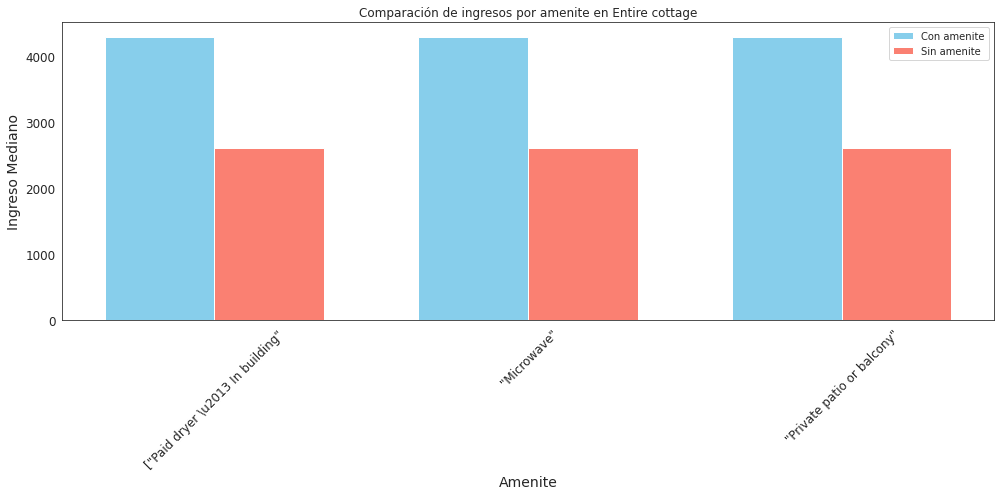

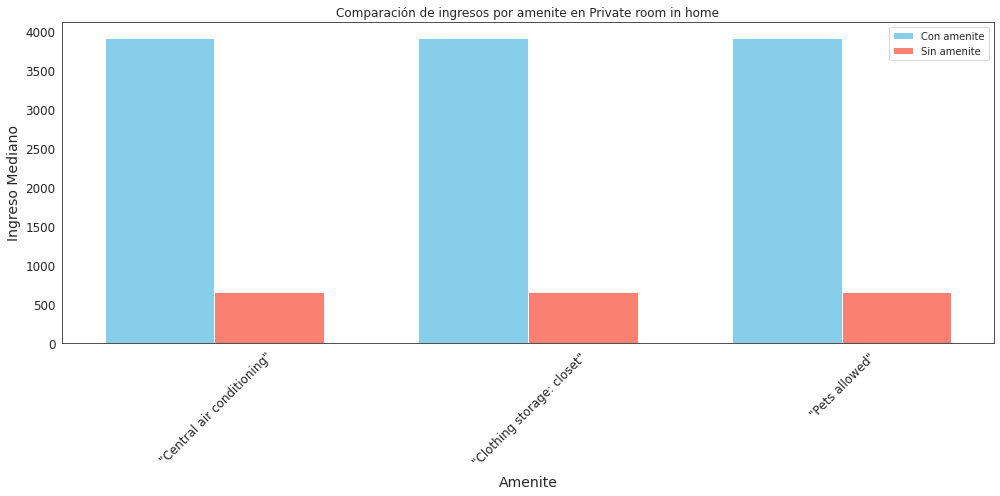

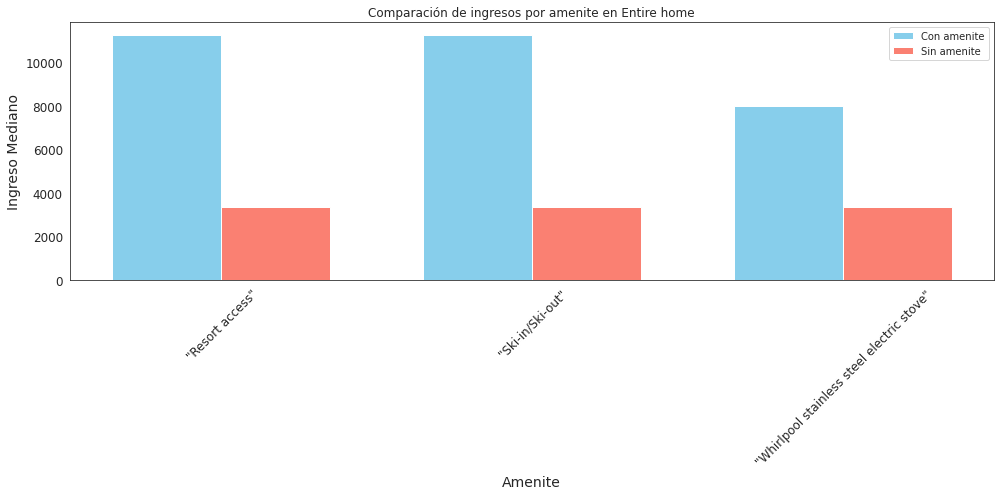

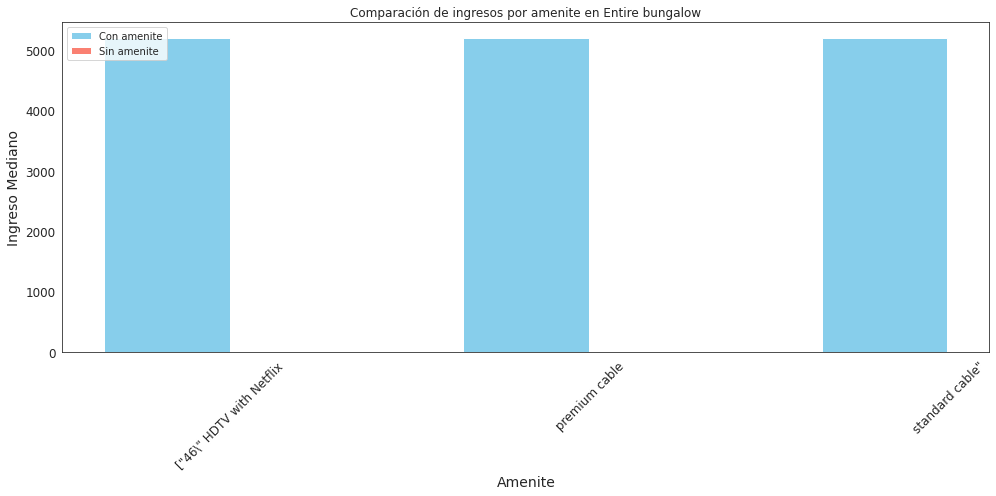

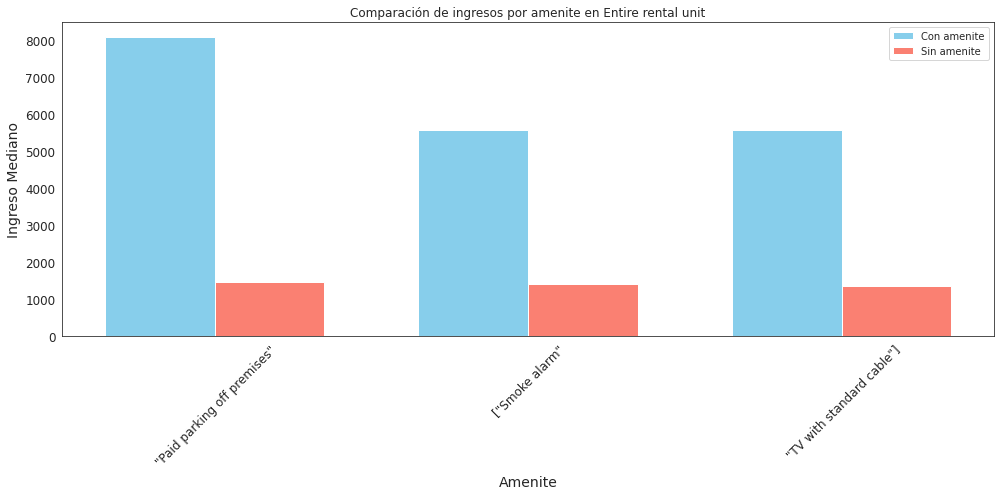

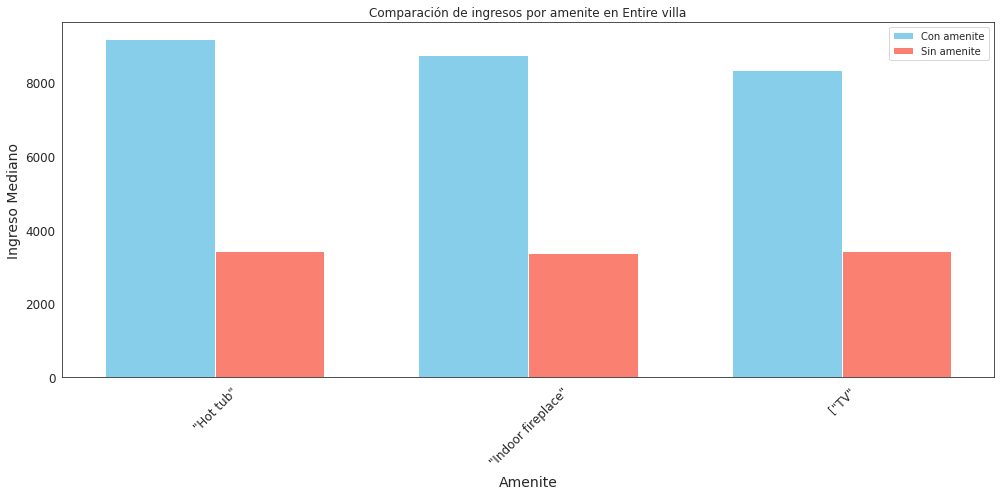

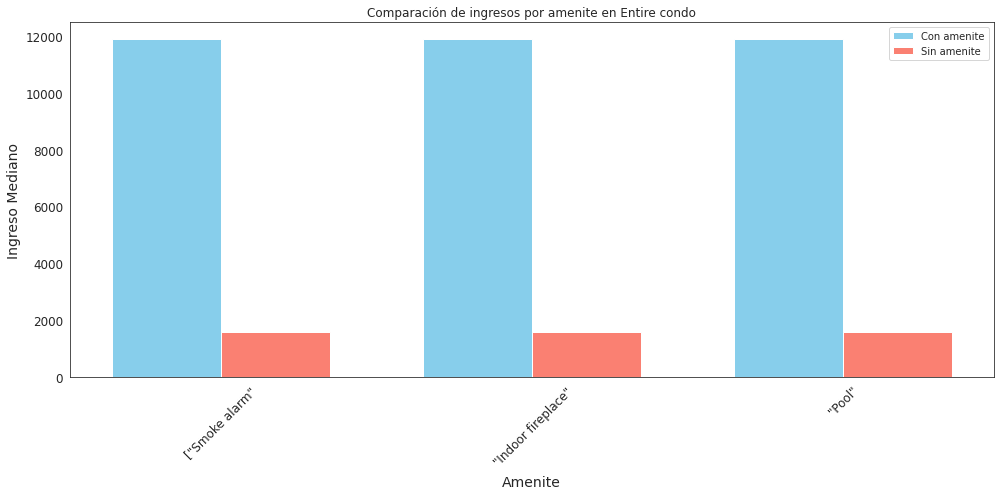

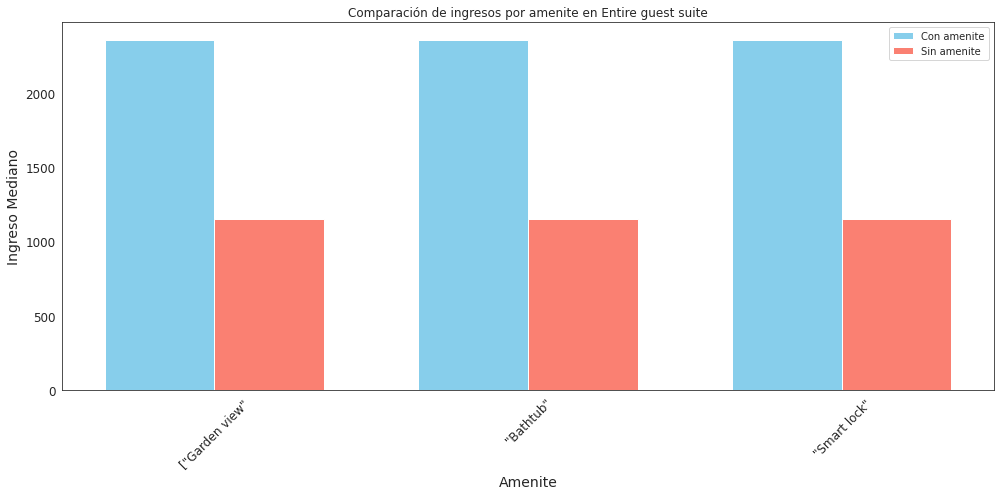

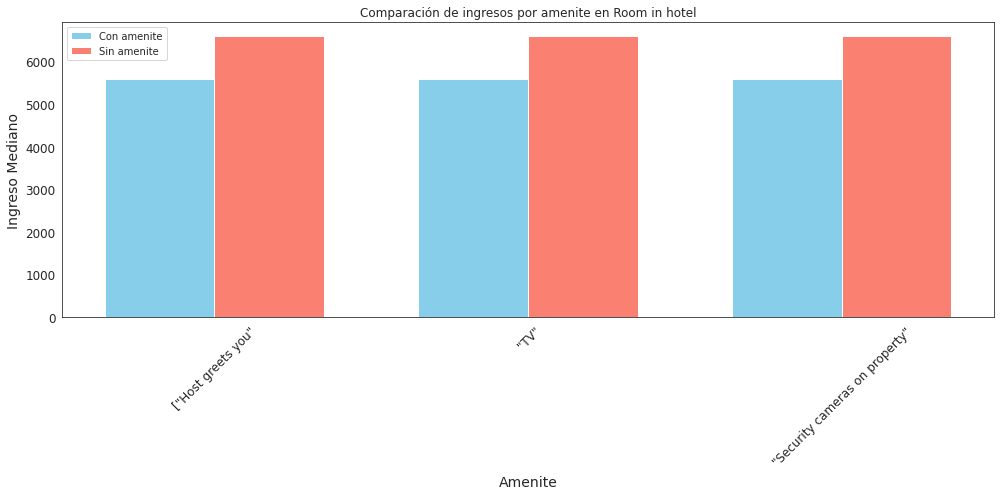

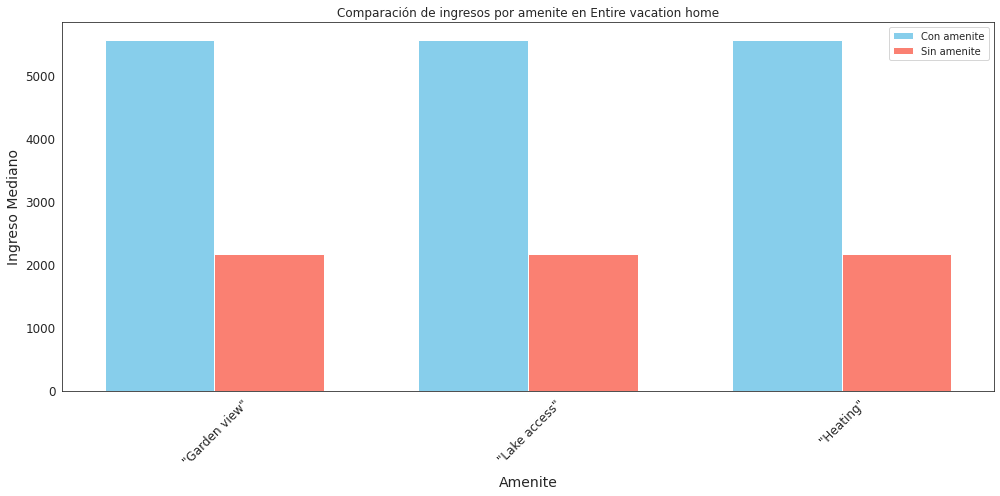

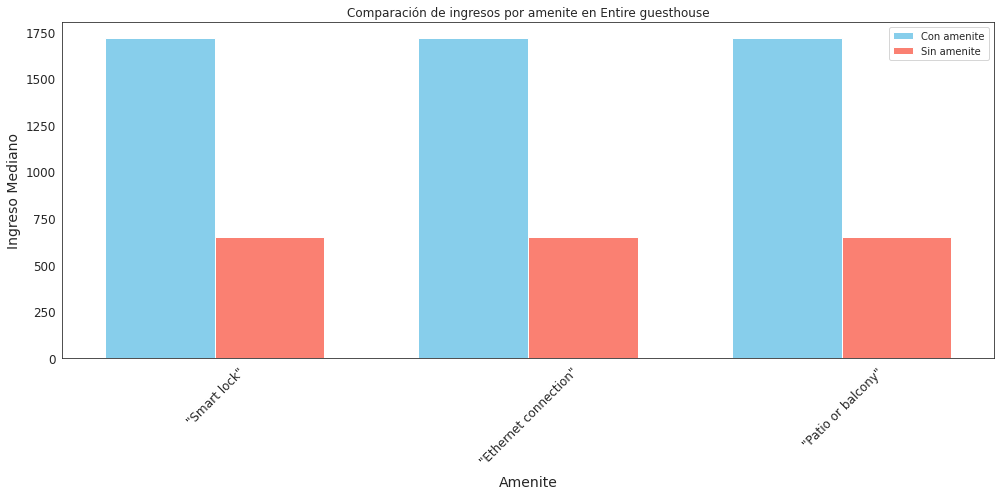

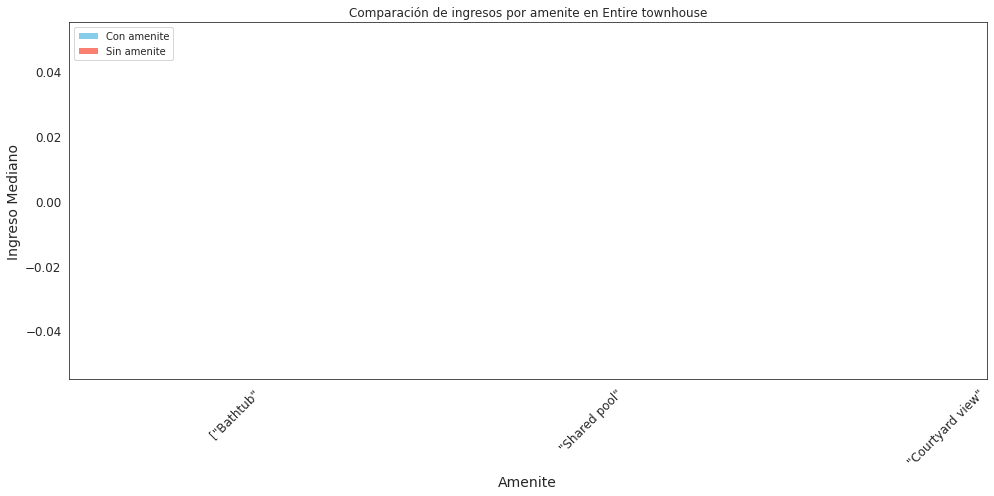

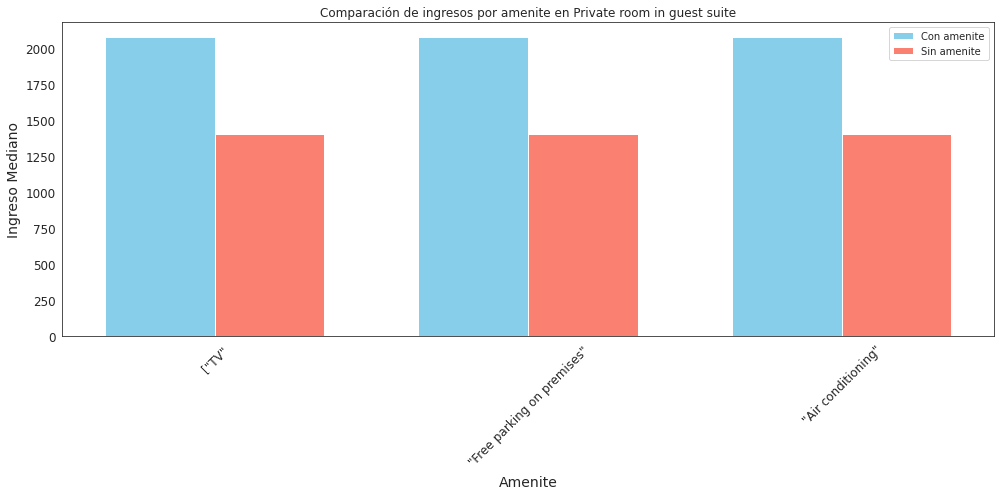

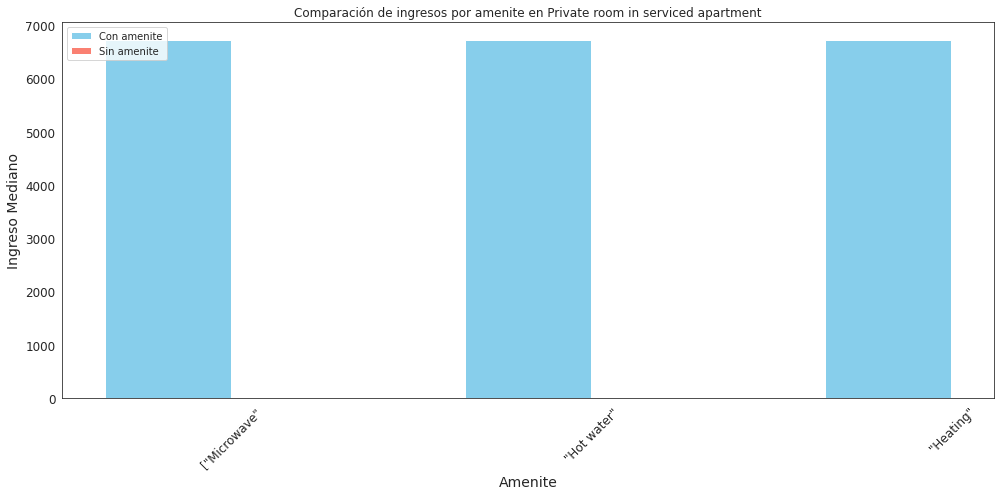

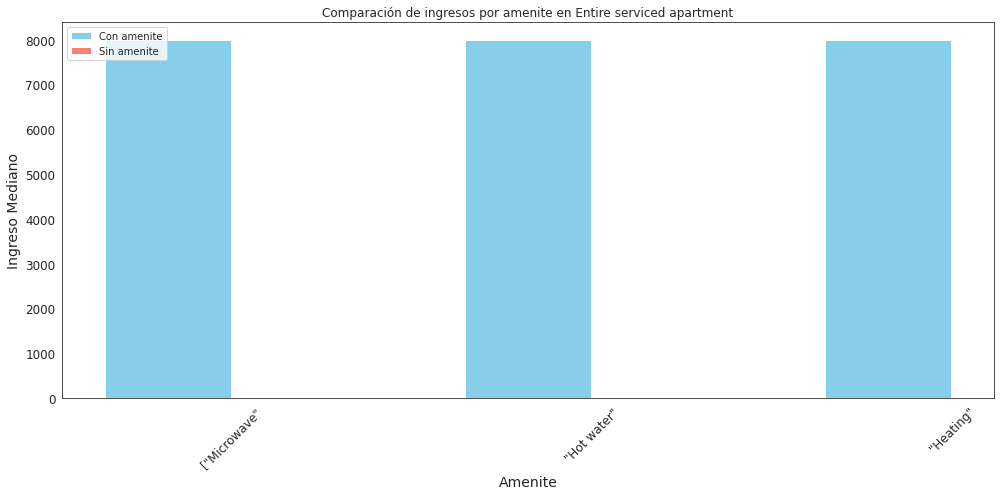

In [41]:
def plot_top_amenities_by_property(df):
    property_types = df['property_type'].unique()
    
    for prop_type in property_types:
        prop_data = df[df['property_type'] == prop_type]
        
        # Identifying the amenities with the highest average revenue for the current property type
        amenities_list = prop_data['amenities'].str.split(',').explode().unique()
        amenity_revenue = {}
        
        for amenity in amenities_list:
            amenity_revenue[amenity] = prop_data[prop_data['amenities'].str.contains(amenity, case=False, na=False, regex=False)]['monthly_revenue'].mean()
        
        sorted_amenities = sorted(amenity_revenue, key=amenity_revenue.get, reverse=True)[:3]
        
        # Comparing the revenue for listings with and without each top amenity
        revenue_with_amenity = []
        revenue_without_amenity = []
        
        for amenity in sorted_amenities:
            revenue_with_amenity.append(prop_data[prop_data['amenities'].str.contains(amenity, case=False, na=False, regex=False)]['monthly_revenue'].median())
            revenue_without_amenity.append(prop_data[~prop_data['amenities'].str.contains(amenity, case=False, na=False, regex=False)]['monthly_revenue'].median())
        
        # Plotting the comparison
        x = np.arange(len(sorted_amenities))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(14, 7))
        rects1 = ax.bar(x - width/2, revenue_with_amenity, width, label='Con amenite', color='skyblue')
        rects2 = ax.bar(x + width/2, revenue_without_amenity, width, label='Sin amenite', color='salmon')
        
        ax.set_xlabel('Amenite')
        ax.set_ylabel('Ingreso Mediano')
        ax.set_title(f'Comparación de ingresos por amenite en {prop_type}')
        ax.set_xticks(x)
        ax.set_xticklabels(sorted_amenities, rotation=45)
        ax.legend()
        
        fig.tight_layout()
        plt.show()

# Calling the function with the neighbourhood_higth_revenue dataframe
plot_top_amenities_by_property(neighbourhood_higth_revenue)


## Instant bookable

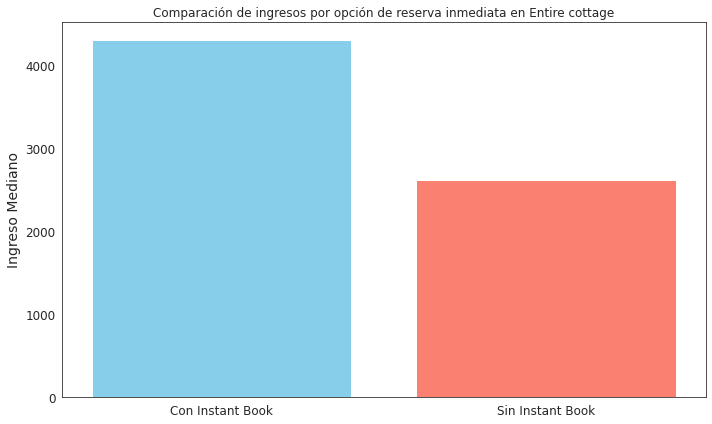

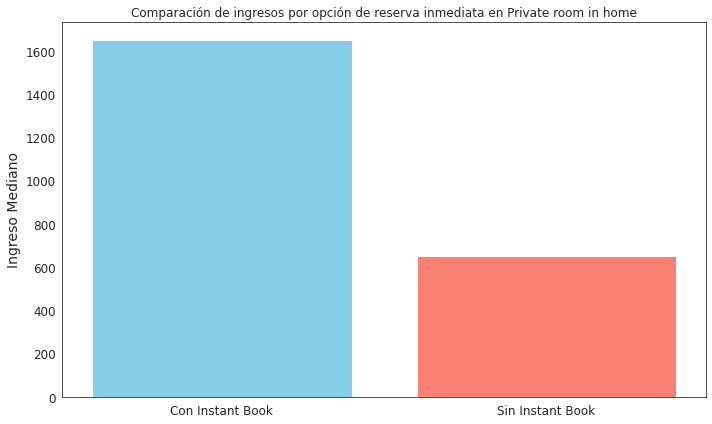

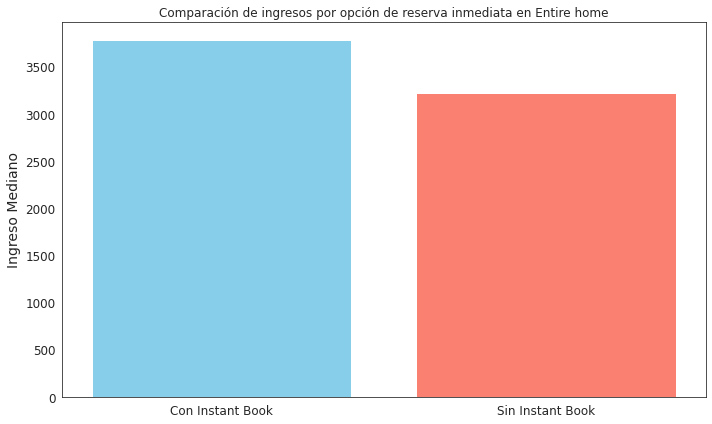

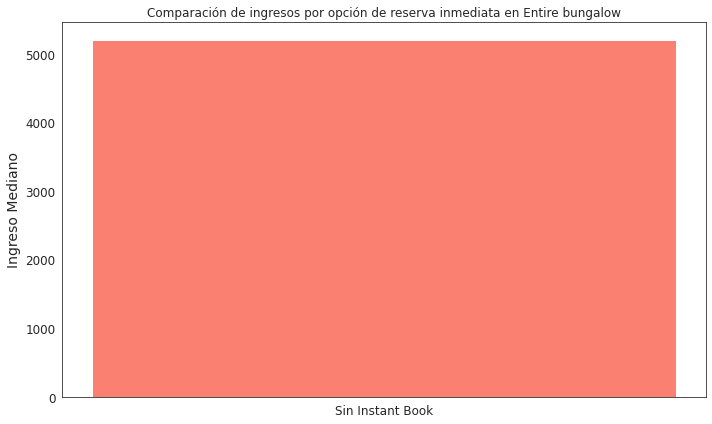

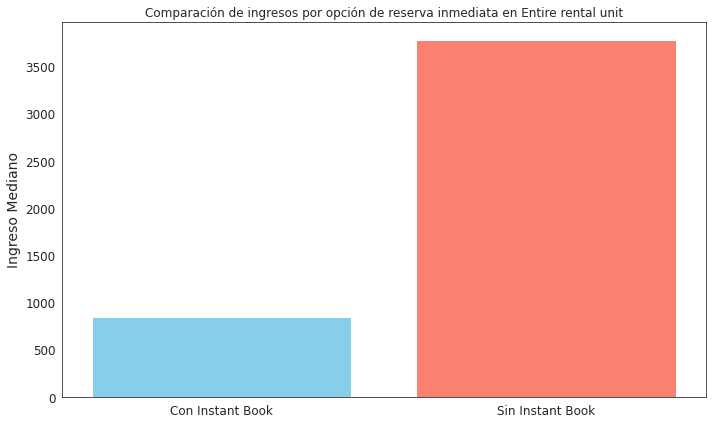

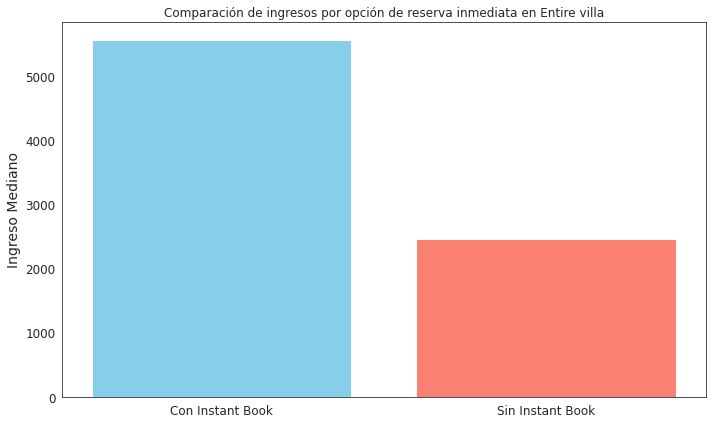

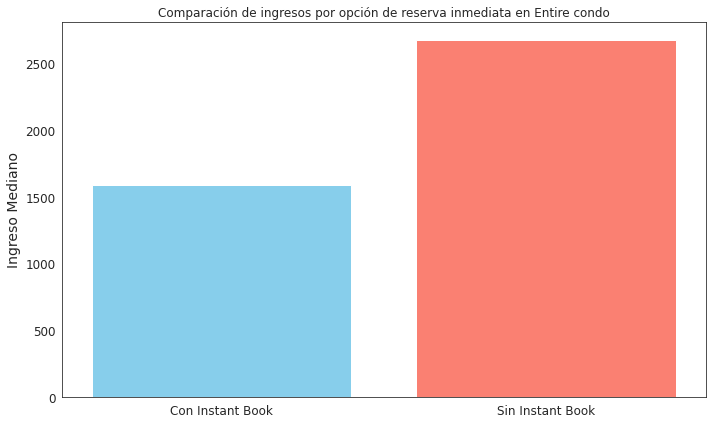

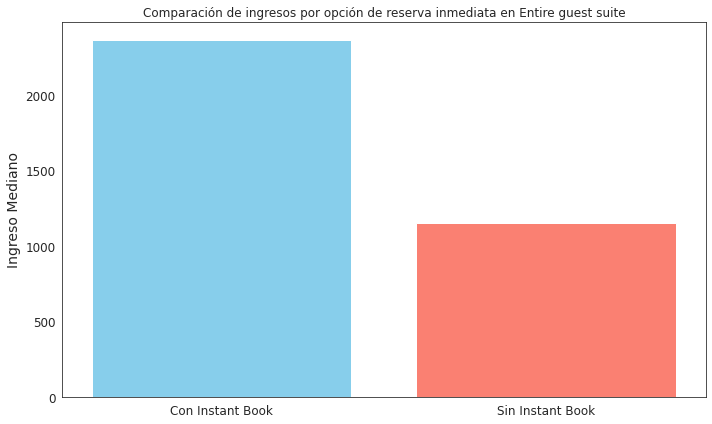

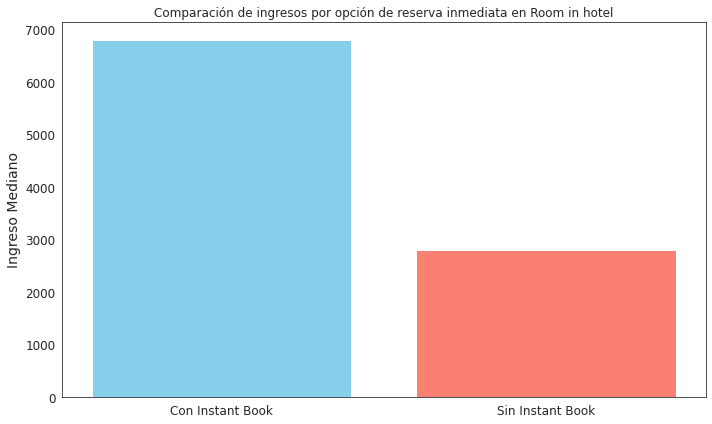

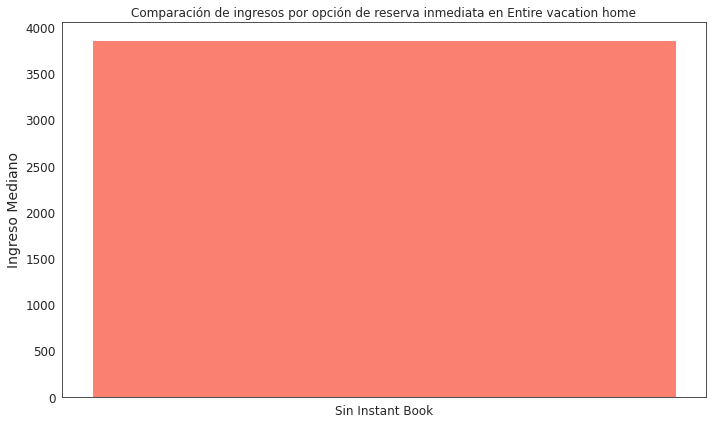

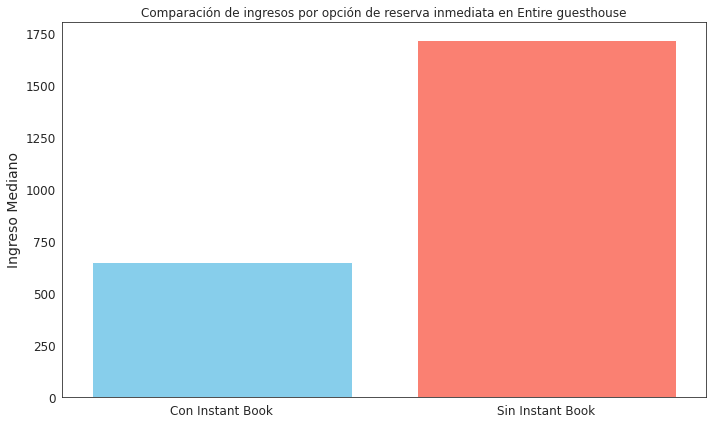

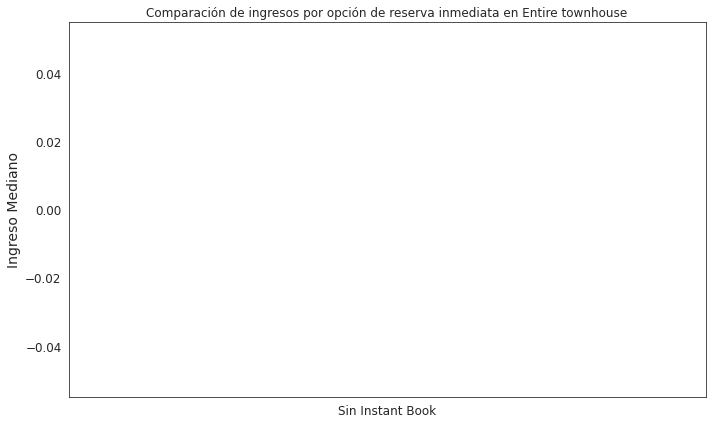

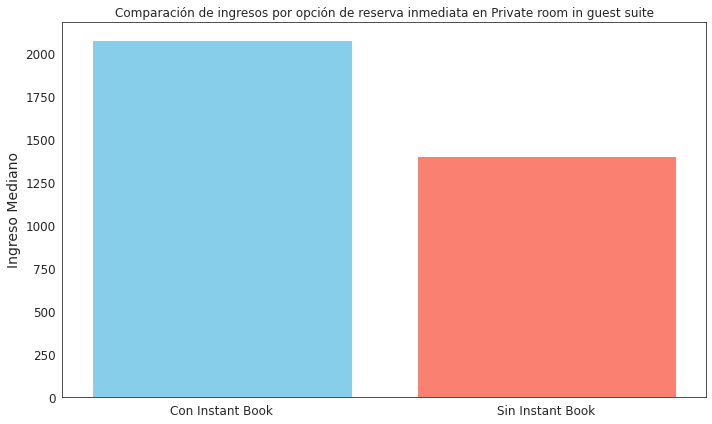

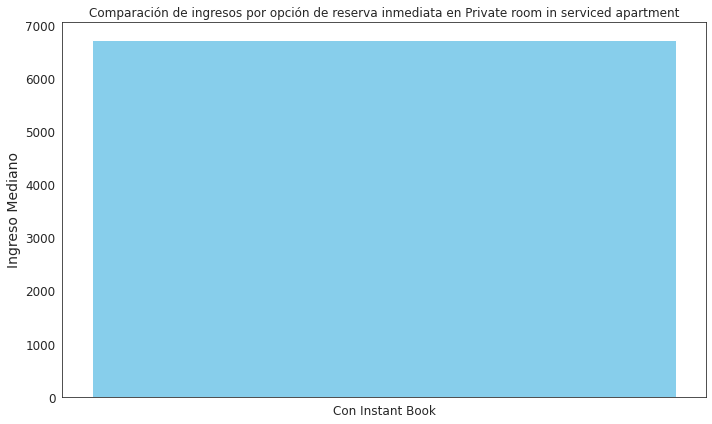

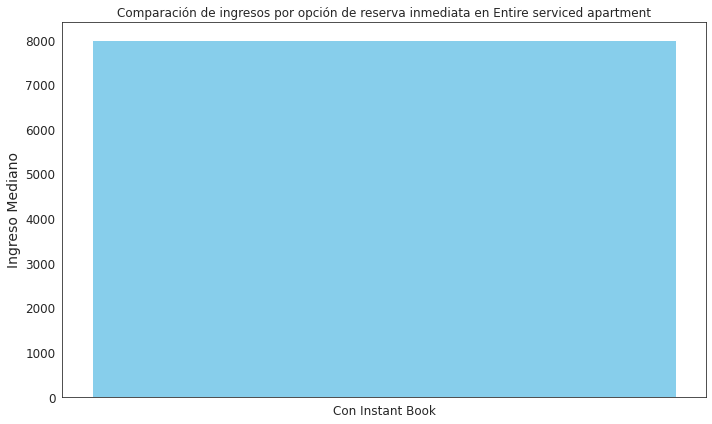

In [43]:
def plot_instant_bookable_by_neighbourhood(df):
    neighbourhoods = df['neighbourhood_cleansed'].unique()
    
    for neighbourhood in neighbourhoods:
        neighbourhood_data = df[df['neighbourhood_cleansed'] == neighbourhood]
        
        # Calculating median revenue for listings with and without instant bookable
        revenue_with_ib = neighbourhood_data[neighbourhood_data['instant_bookable'] == 't']['monthly_revenue'].median()
        revenue_without_ib = neighbourhood_data[neighbourhood_data['instant_bookable'] == 'f']['monthly_revenue'].median()
        
        # Plotting the comparison
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(['Con Instant Book', 'Sin Instant Book'], [revenue_with_ib, revenue_without_ib], color=['skyblue', 'salmon'])
        
        ax.set_ylabel('Ingreso Mediano')
        ax.set_title(f'Comparación de ingresos por opción de reserva inmediata en {neighbourhood}')
        
        fig.tight_layout()
        plt.show()

# Placeholder call (will throw an error if executed here, but this is the function structure)
plot_instant_bookable_comparison(neighbourhood_higth_revenue)

